# Exploratory Data Analysis (EDA)

This notebook analyzes the preprocessed financial data across different timeframes (1d, 1wk, 1mo) and performs correlation analysis on technical indicators with close price and class labels.

## Overview
- **Data Source**: Preprocessed data from `data/yfinance/train/` directories
- **Timeframes**: 1d (daily), 1wk (weekly), 1mo (monthly)
- **Analysis**: Correlation analysis between technical indicators and target variables (Close price, Label, Label2)
- **Labels**: 
  - **Label**: Original sliding window-based labeling (Buy/Sell/Hold)
  - **Label2**: Next-day return-based labeling (Buy if next day +2%+, Sell if next day -2%-, Hold otherwise)
- **Technical Indicators**: 
  - **Moving Averages**: SMA20, EMA20, WMA20, HMA20, TEMA20, VWMA20, KAMA10, DEMA20, ZLMA20, TRIMA20
  - **Momentum**: RSI14, STOCH%K, STOCHRSI, CMO14, ROC10, MOM10, TSI25_13
  - **Volatility**: ATR14, BBP, Ulcer
  - **Volume**: OBV, CMF, PVT, NVI, PVI, AD, EOM, EFI, ADOSC, VWAP
  - **Trend**: CCI20, PPO, MACD, AO, KST, WILLR, DPO20, ADX14, AROONOSC, PSAR, SUPERTd
  - **Statistical**: KCH, ZScore20, RVI

## Data Structure
- **Date Column**: Proper datetime index for time series analysis
- **Symbol Column**: Stock ticker symbols for multi-asset analysis
- **Label Column**: Target variable for prediction (sliding window method)
- **Label2 Column**: Alternative target variable (next-day return method)
- **Close Column**: Stock closing prices
- **44 Technical Indicators**: Comprehensive set of trading indicators

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Configure pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

## Data Loading and Exploration

In [2]:
# Define paths
base_dir = Path("data/yfinance/train")
timeframes = ['1d', '1wk', '1mo']

# Function to load and combine data for a specific timeframe
def load_timeframe_data(timeframe):
    """Load all CSV files for a specific timeframe and combine them."""
    timeframe_dir = base_dir / timeframe
    
    if not timeframe_dir.exists():
        print(f"Directory {timeframe_dir} does not exist")
        return None
    
    # Get all CSV files
    csv_files = list(timeframe_dir.glob("*.csv"))
    print(f"Found {len(csv_files)} files for {timeframe} timeframe")
    
    # Load and combine all data
    dataframes = []
    for file in csv_files:
        try:
            # Load CSV with Date column as index
            df = pd.read_csv(file, parse_dates=['Date'], index_col='Date')
            
            # Extract symbol name from new filename format
            # Format: SYMBOL_starttime_endtime_train.csv
            symbol = file.stem.split('_')[0]
            df['Symbol'] = symbol
            df['Timeframe'] = timeframe
            dataframes.append(df)
            
        except Exception as e:
            print(f"Error loading {file}: {e}")
    
    if dataframes:
        combined_df = pd.concat(dataframes, ignore_index=False)
        # Reset index to make Date a column for easier analysis
        combined_df = combined_df.reset_index()
        print(f"Combined data shape for {timeframe}: {combined_df.shape}")
        return combined_df
    else:
        return None

# Load data for all timeframes
data_dict = {}
for tf in timeframes:
    data_dict[tf] = load_timeframe_data(tf)

Found 29 files for 1d timeframe
Combined data shape for 1d: (151731, 50)
Found 29 files for 1wk timeframe
Combined data shape for 1wk: (31431, 50)
Found 29 files for 1mo timeframe
Combined data shape for 1mo: (7205, 50)


## Data Overview

In [3]:
# Display basic information for each timeframe
for timeframe, df in data_dict.items():
    if df is not None:
        print(f"\n{'='*50}")
        print(f"TIMEFRAME: {timeframe}")
        print(f"{'='*50}")
        print(f"Shape: {df.shape}")
        print(f"Columns: {list(df.columns)}")
        print(f"\nData Types:")
        print(df.dtypes)
        print(f"\nMissing Values:")
        print(df.isnull().sum())
        print(f"\nLabel Distribution:")
        print(df['Label'].value_counts().sort_index())
        
        # Check if Label2 exists and show its distribution
        if 'Label2' in df.columns:
            print(f"\nLabel2 Distribution:")
            print(df['Label2'].value_counts().sort_index())
        else:
            print(f"\nLabel2 not found in {timeframe} data")
            
        print(f"\nUnique Symbols: {df['Symbol'].nunique()}")
        print(f"Symbols: {sorted(df['Symbol'].unique())}")
        print(f"\nFirst few rows:")
        print(df.head())


TIMEFRAME: 1d
Shape: (151731, 50)
Columns: ['Date', 'SMA20', 'EMA20', 'WMA20', 'HMA20', 'TEMA20', 'VWMA20', 'KAMA10', 'DEMA20', 'ZLMA20', 'TRIMA20', 'RSI14', 'STOCH%K', 'STOCHRSI', 'CCI20', 'CMO14', 'ROC10', 'PPO', 'MACD', 'AO', 'KST', 'WILLR', 'MOM10', 'DPO20', 'TSI25_13', 'ADX14', 'AROONOSC', 'PSAR', 'SUPERTd', 'BBP', 'ATR14', 'KCH', 'ZScore20', 'RVI', 'OBV', 'CMF', 'PVT', 'NVI', 'PVI', 'AD', 'EOM', 'EFI', 'ADOSC', 'VWAP', 'Ulcer', 'Label', 'Label2', 'Close', 'Symbol', 'Timeframe']

Data Types:
Date         datetime64[ns]
SMA20               float64
EMA20               float64
WMA20               float64
HMA20               float64
TEMA20              float64
VWMA20              float64
KAMA10              float64
DEMA20              float64
ZLMA20              float64
TRIMA20             float64
RSI14               float64
STOCH%K             float64
STOCHRSI            float64
CCI20               float64
CMO14               float64
ROC10               float64
PPO                 f

## Statistical Summary

In [4]:
# Statistical summary for each timeframe
for timeframe, df in data_dict.items():
    if df is not None:
        print(f"\n{'='*60}")
        print(f"STATISTICAL SUMMARY - {timeframe.upper()}")
        print(f"{'='*60}")
        
        # Exclude non-numeric columns for summary
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        print(df[numeric_cols].describe())
        
        print(f"\nLabel Statistics:")
        print(f"Mean Label: {df['Label'].mean():.4f}")
        print(f"Std Label: {df['Label'].std():.4f}")
        print(f"Min Label: {df['Label'].min()}")
        print(f"Max Label: {df['Label'].max()}")
        
        # Add Label2 statistics if it exists
        if 'Label2' in df.columns:
            print(f"\nLabel2 Statistics:")
            print(f"Mean Label2: {df['Label2'].mean():.4f}")
            print(f"Std Label2: {df['Label2'].std():.4f}")
            print(f"Min Label2: {df['Label2'].min()}")
            print(f"Max Label2: {df['Label2'].max()}")
        else:
            print(f"\nLabel2 not found in {timeframe} data")


STATISTICAL SUMMARY - 1D
               SMA20          EMA20          WMA20          HMA20  \
count  151180.000000  151180.000000  151180.000000  151093.000000   
mean        0.101761       0.102417       0.101881       0.099975   
std         0.100331       0.100929       0.100481       0.098713   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.035932       0.036189       0.035962       0.035288   
50%         0.067797       0.068224       0.067855       0.066608   
75%         0.132158       0.133009       0.132418       0.129782   
max         0.866780       0.871666       0.873885       0.874262   

              TEMA20         VWMA20         KAMA10         DEMA20  \
count  151180.000000  151180.000000  151470.000000  151180.000000   
mean        0.100220       0.101659       0.102103       0.100484   
std         0.098987       0.100191       0.100590       0.099255   
min         0.000000       0.000000       0.000000       0.000000   
25%    

## Correlation Analysis

In [5]:
# Define technical indicators (excluding Date, Label, Label2, Close, Symbol, Timeframe)
# Updated to match the new CSV structure
technical_indicators = [
    'SMA20', 'EMA20', 'WMA20', 'HMA20', 'TEMA20', 'VWMA20', 'KAMA10', 'DEMA20', 'ZLMA20', 'TRIMA20',
    'RSI14', 'STOCH%K', 'STOCHRSI', 'CCI20', 'CMO14', 'ROC10', 'PPO', 'MACD', 'AO', 'KST', 
    'WILLR', 'MOM10', 'DPO20', 'TSI25_13', 'ADX14', 'AROONOSC', 'PSAR', 'SUPERTd', 'BBP',
    'ATR14', 'KCH', 'ZScore20', 'RVI', 'OBV', 'CMF', 'PVT', 'NVI', 'PVI', 'AD', 'EOM', 
    'EFI', 'ADOSC', 'VWAP', 'Ulcer'
]

# Function to calculate correlations
def calculate_correlations(df, timeframe_name):
    """Calculate correlations between technical indicators and target variables."""
    
    # Ensure all required columns exist
    available_indicators = [ind for ind in technical_indicators if ind in df.columns]
    
    if 'Close' not in df.columns or 'Label' not in df.columns:
        print(f"Missing Close or Label columns in {timeframe_name}")
        return None, None, None
    
    # Calculate correlations with Close price
    close_correlations = df[available_indicators + ['Close']].corr()['Close'].drop('Close')
    
    # Calculate correlations with Label
    label_correlations = df[available_indicators + ['Label']].corr()['Label'].drop('Label')
    
    # Calculate correlations with Label2 if it exists
    label2_correlations = None
    if 'Label2' in df.columns:
        label2_correlations = df[available_indicators + ['Label2']].corr()['Label2'].drop('Label2')
    
    return close_correlations, label_correlations, label2_correlations

# Calculate correlations for all timeframes
correlation_results = {}
for timeframe, df in data_dict.items():
    if df is not None:
        close_corr, label_corr, label2_corr = calculate_correlations(df, timeframe)
        if close_corr is not None and label_corr is not None:
            correlation_results[timeframe] = {
                'close_correlations': close_corr,
                'label_correlations': label_corr,
                'label2_correlations': label2_corr  # Will be None if Label2 doesn't exist
            }

## Correlation Results

In [ ]:
# Display correlation results
for timeframe, results in correlation_results.items():
    print(f"\n{'='*60}")
    print(f"CORRELATION ANALYSIS - {timeframe.upper()}")
    print(f"{'='*60}")
    
    # Close correlations
    close_corr_df = pd.DataFrame({
        'Indicator': results['close_correlations'].index,
        'Correlation': results['close_correlations'].values
    }).sort_values('Correlation', key=abs, ascending=False)
    
    print(f"\nTop 10 Correlations with Close Price:")
    print(close_corr_df.head(10).to_string(index=False))
    
    # Label correlations  
    label_corr_df = pd.DataFrame({
        'Indicator': results['label_correlations'].index,
        'Correlation': results['label_correlations'].values
    }).sort_values('Correlation', key=abs, ascending=False)
    
    print(f"\nTop 10 Correlations with Label:")
    print(label_corr_df.head(15).to_string(index=False))
    
    # Label2 correlations if available
    if results['label2_correlations'] is not None:
        label2_corr_df = pd.DataFrame({
            'Indicator': results['label2_correlations'].index,
            'Correlation': results['label2_correlations'].values
        }).sort_values('Correlation', key=abs, ascending=False)
        
        print(f"\nTop 10 Correlations with Label2 (Next-Day Return):")
        print(label2_corr_df.head(10).to_string(index=False))
    else:
        print(f"\nLabel2 correlations not available for {timeframe}")


CORRELATION ANALYSIS - 1D

Top 10 Correlations with Close Price:
Indicator  Correlation
     VWAP     0.999973
   TEMA20     0.999592
   ZLMA20     0.999506
   DEMA20     0.999399
    HMA20     0.999396
    WMA20     0.998966
     PSAR     0.998960
   KAMA10     0.998949
    EMA20     0.998743
      KCH     0.998657

Top 10 Correlations with Label:
Indicator  Correlation
    DPO20     0.094405
    WILLR     0.083441
      BBP     0.081259
 ZScore20     0.081259
      RVI     0.075235
    CCI20     0.074264
    CMO14     0.069791
    RSI14     0.069791
 STOCHRSI     0.063486
    ROC10     0.056092

Top 10 Correlations with Label2 (Next-Day Return):
Indicator  Correlation
    Ulcer     0.282056
 TSI25_13    -0.135366
    RSI14    -0.133006
    CMO14    -0.133006
    ATR14     0.120792
      PPO    -0.119008
      KST    -0.115232
     MACD    -0.109546
 ZScore20    -0.106640
      BBP    -0.106640

CORRELATION ANALYSIS - 1WK

Top 10 Correlations with Close Price:
Indicator  Correlation


## Correlation Visualization

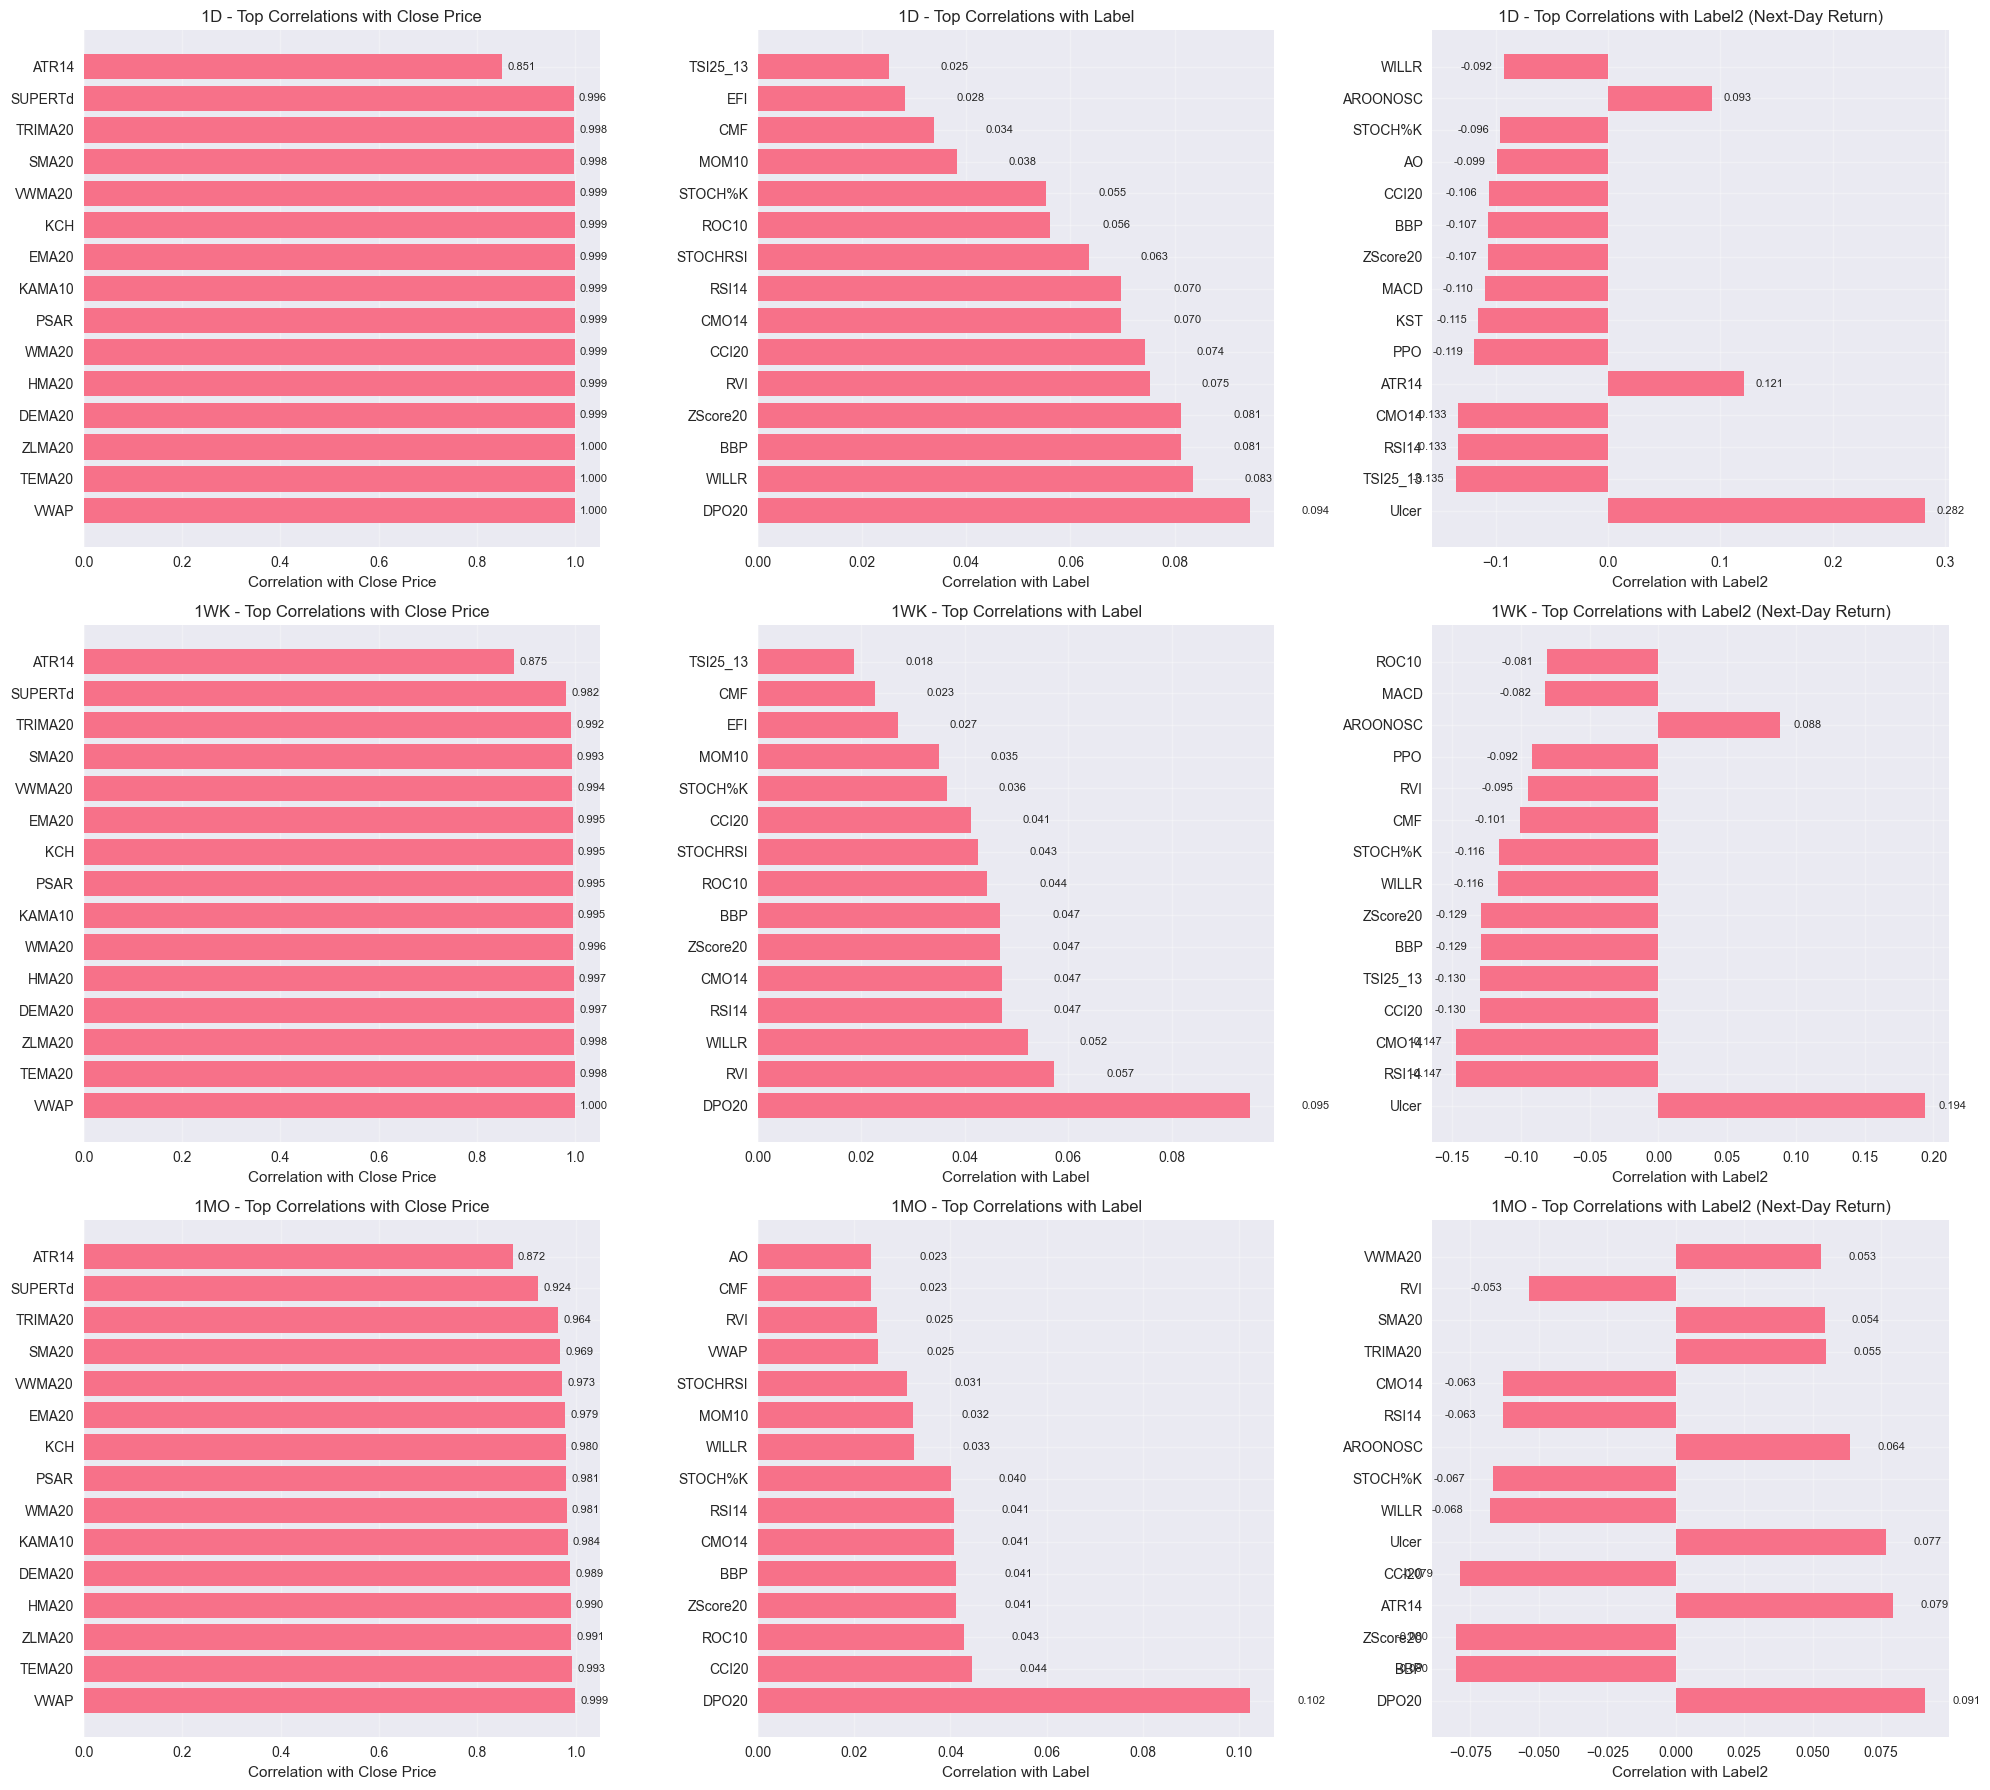

In [7]:
# Create correlation visualizations
n_timeframes = len(correlation_results)
n_cols = 3 if any(results['label2_correlations'] is not None for results in correlation_results.values()) else 2

fig, axes = plt.subplots(n_timeframes, n_cols, figsize=(20, 6*n_timeframes))
if n_timeframes == 1:
    axes = axes.reshape(1, -1)

for idx, (timeframe, results) in enumerate(correlation_results.items()):
    # Close correlations
    close_corr = results['close_correlations'].sort_values(key=abs, ascending=False)
    top_close = close_corr.head(15)
    
    bars1 = axes[idx, 0].barh(range(len(top_close)), top_close.values)
    axes[idx, 0].set_yticks(range(len(top_close)))
    axes[idx, 0].set_yticklabels(top_close.index)
    axes[idx, 0].set_xlabel('Correlation with Close Price')
    axes[idx, 0].set_title(f'{timeframe.upper()} - Top Correlations with Close Price')
    axes[idx, 0].grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, value in zip(bars1, top_close.values):
        axes[idx, 0].text(bar.get_width() + (0.01 if value > 0 else -0.01), 
                         bar.get_y() + bar.get_height()/2,
                         f'{value:.3f}', ha='left' if value > 0 else 'right', va='center', fontsize=8)
    
    # Label correlations
    label_corr = results['label_correlations'].sort_values(key=abs, ascending=False)
    top_label = label_corr.head(15)
    
    bars2 = axes[idx, 1].barh(range(len(top_label)), top_label.values)
    axes[idx, 1].set_yticks(range(len(top_label)))
    axes[idx, 1].set_yticklabels(top_label.index)
    axes[idx, 1].set_xlabel('Correlation with Label')
    axes[idx, 1].set_title(f'{timeframe.upper()} - Top Correlations with Label')
    axes[idx, 1].grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, value in zip(bars2, top_label.values):
        axes[idx, 1].text(bar.get_width() + (0.01 if value > 0 else -0.01), 
                         bar.get_y() + bar.get_height()/2,
                         f'{value:.3f}', ha='left' if value > 0 else 'right', va='center', fontsize=8)
    
    # Label2 correlations if available
    if n_cols == 3 and results['label2_correlations'] is not None:
        label2_corr = results['label2_correlations'].sort_values(key=abs, ascending=False)
        top_label2 = label2_corr.head(15)
        
        bars3 = axes[idx, 2].barh(range(len(top_label2)), top_label2.values)
        axes[idx, 2].set_yticks(range(len(top_label2)))
        axes[idx, 2].set_yticklabels(top_label2.index)
        axes[idx, 2].set_xlabel('Correlation with Label2')
        axes[idx, 2].set_title(f'{timeframe.upper()} - Top Correlations with Label2 (Next-Day Return)')
        axes[idx, 2].grid(True, alpha=0.3)
        
        # Add value labels on bars
        for bar, value in zip(bars3, top_label2.values):
            axes[idx, 2].text(bar.get_width() + (0.01 if value > 0 else -0.01), 
                             bar.get_y() + bar.get_height()/2,
                             f'{value:.3f}', ha='left' if value > 0 else 'right', va='center', fontsize=8)

plt.tight_layout()
plt.show()

## Label vs Label2 Correlation Comparison

This section compares how technical indicators correlate with the original Label (sliding window) vs Label2 (next-day return).

In [8]:
# Compare Label vs Label2 correlations
label_comparison_results = {}

for timeframe, results in correlation_results.items():
    if results['label2_correlations'] is not None:
        # Create comparison dataframe
        comparison_df = pd.DataFrame({
            'Label_Correlation': results['label_correlations'],
            'Label2_Correlation': results['label2_correlations']
        }).fillna(0)
        
        # Calculate absolute values for comparison
        comparison_df['Abs_Label'] = comparison_df['Label_Correlation'].abs()
        comparison_df['Abs_Label2'] = comparison_df['Label2_Correlation'].abs()
        comparison_df['Difference'] = comparison_df['Abs_Label2'] - comparison_df['Abs_Label']
        
        label_comparison_results[timeframe] = comparison_df
        
        print(f"\n{'='*70}")
        print(f"LABEL vs LABEL2 CORRELATION COMPARISON - {timeframe.upper()}")
        print(f"{'='*70}")
        
        # Indicators where Label2 correlation is stronger
        better_label2 = comparison_df[comparison_df['Difference'] > 0.05].sort_values('Difference', ascending=False)
        print(f"\nIndicators with stronger Label2 correlation (difference > 0.05):")
        if len(better_label2) > 0:
            for indicator in better_label2.head(10).index:
                label_corr = comparison_df.loc[indicator, 'Label_Correlation']
                label2_corr = comparison_df.loc[indicator, 'Label2_Correlation']
                diff = comparison_df.loc[indicator, 'Difference']
                print(f"  {indicator}: Label={label_corr:.3f}, Label2={label2_corr:.3f} (diff: +{diff:.3f})")
        else:
            print("  No indicators show significantly stronger Label2 correlation")
        
        # Indicators where Label correlation is stronger
        better_label = comparison_df[comparison_df['Difference'] < -0.05].sort_values('Difference', ascending=True)
        print(f"\nIndicators with stronger Label correlation (difference < -0.05):")
        if len(better_label) > 0:
            for indicator in better_label.head(10).index:
                label_corr = comparison_df.loc[indicator, 'Label_Correlation']
                label2_corr = comparison_df.loc[indicator, 'Label2_Correlation']
                diff = comparison_df.loc[indicator, 'Difference']
                print(f"  {indicator}: Label={label_corr:.3f}, Label2={label2_corr:.3f} (diff: {diff:.3f})")
        else:
            print("  No indicators show significantly stronger Label correlation")
        
        # Summary statistics
        print(f"\nSummary Statistics:")
        print(f"  Mean |Label| correlation: {comparison_df['Abs_Label'].mean():.3f}")
        print(f"  Mean |Label2| correlation: {comparison_df['Abs_Label2'].mean():.3f}")
        print(f"  Mean difference (Label2 - Label): {comparison_df['Difference'].mean():.3f}")
        print(f"  Indicators favoring Label2: {(comparison_df['Difference'] > 0).sum()}")
        print(f"  Indicators favoring Label: {(comparison_df['Difference'] < 0).sum()}")
    else:
        print(f"\nLabel2 not available for {timeframe} - skipping comparison")


LABEL vs LABEL2 CORRELATION COMPARISON - 1D

Indicators with stronger Label2 correlation (difference > 0.05):
  Ulcer: Label=-0.005, Label2=0.282 (diff: +0.277)
  ATR14: Label=0.000, Label2=0.121 (diff: +0.121)
  TSI25_13: Label=0.025, Label2=-0.135 (diff: +0.110)
  PPO: Label=0.011, Label2=-0.119 (diff: +0.108)
  KST: Label=0.009, Label2=-0.115 (diff: +0.106)
  MACD: Label=0.014, Label2=-0.110 (diff: +0.096)
  AO: Label=0.012, Label2=-0.099 (diff: +0.087)
  AROONOSC: Label=-0.011, Label2=0.093 (diff: +0.082)
  RSI14: Label=0.070, Label2=-0.133 (diff: +0.063)
  CMO14: Label=0.070, Label2=-0.133 (diff: +0.063)

Indicators with stronger Label correlation (difference < -0.05):
  DPO20: Label=0.094, Label2=0.038 (diff: -0.057)

Summary Statistics:
  Mean |Label| correlation: 0.024
  Mean |Label2| correlation: 0.061
  Mean difference (Label2 - Label): 0.036
  Indicators favoring Label2: 41
  Indicators favoring Label: 3

LABEL vs LABEL2 CORRELATION COMPARISON - 1WK

Indicators with stronge

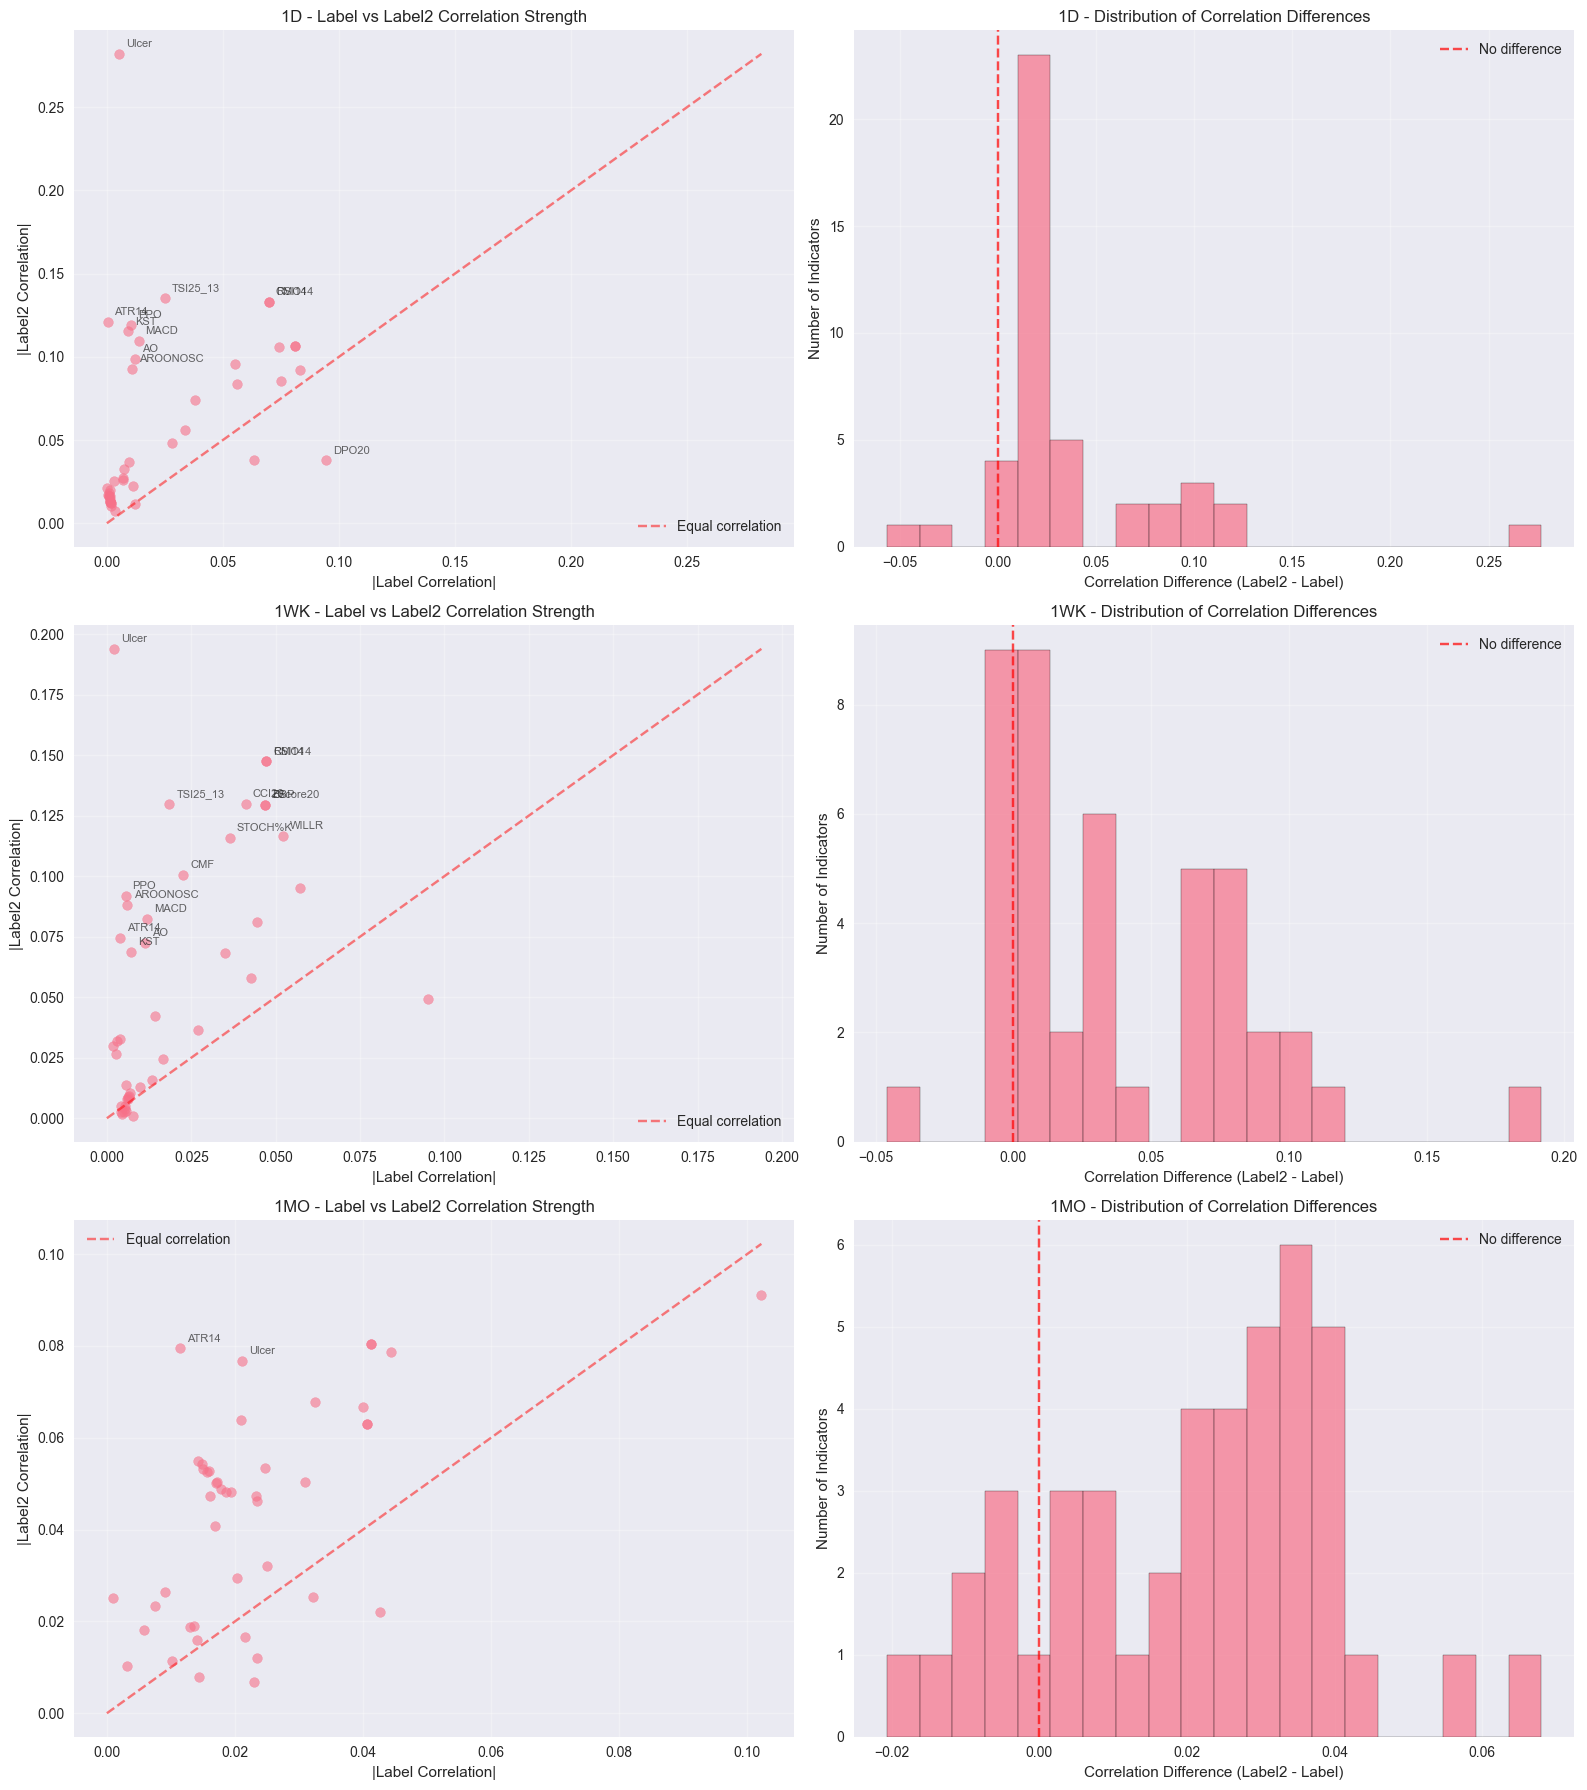

In [9]:
# Visualize Label vs Label2 correlation comparison
n_comparisons = len(label_comparison_results)
if n_comparisons > 0:
    fig, axes = plt.subplots(n_comparisons, 2, figsize=(16, 6*n_comparisons))
    if n_comparisons == 1:
        axes = axes.reshape(1, -1)
    
    for idx, (timeframe, comp_df) in enumerate(label_comparison_results.items()):
        # Scatter plot of Label vs Label2 correlations
        axes[idx, 0].scatter(comp_df['Abs_Label'], comp_df['Abs_Label2'], alpha=0.6)
        
        # Add diagonal line for equal correlation
        max_val = max(comp_df['Abs_Label'].max(), comp_df['Abs_Label2'].max())
        axes[idx, 0].plot([0, max_val], [0, max_val], 'r--', alpha=0.5, label='Equal correlation')
        
        axes[idx, 0].set_xlabel('|Label Correlation|')
        axes[idx, 0].set_ylabel('|Label2 Correlation|')
        axes[idx, 0].set_title(f'{timeframe.upper()} - Label vs Label2 Correlation Strength')
        axes[idx, 0].legend()
        axes[idx, 0].grid(True, alpha=0.3)
        
        # Annotate points with largest differences
        large_diff = comp_df[comp_df['Difference'].abs() > 0.05]
        for indicator in large_diff.index:
            axes[idx, 0].annotate(indicator, 
                                 (comp_df.loc[indicator, 'Abs_Label'], 
                                  comp_df.loc[indicator, 'Abs_Label2']),
                                 xytext=(5, 5), textcoords='offset points', 
                                 fontsize=8, alpha=0.7)
        
        # Histogram of correlation differences
        axes[idx, 1].hist(comp_df['Difference'], bins=20, alpha=0.7, edgecolor='black')
        axes[idx, 1].axvline(x=0, color='red', linestyle='--', alpha=0.7, label='No difference')
        axes[idx, 1].set_xlabel('Correlation Difference (Label2 - Label)')
        axes[idx, 1].set_ylabel('Number of Indicators')
        axes[idx, 1].set_title(f'{timeframe.upper()} - Distribution of Correlation Differences')
        axes[idx, 1].legend()
        axes[idx, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("No Label2 data available for comparison")

## Time Lag Correlation Analysis

This section analyzes correlations between technical indicators and labels with different time lags to identify potential predictive relationships.

In [ ]:
# Function to calculate time lag correlations
def calculate_time_lag_correlations(df, max_lag=10):
    """
    Calculate correlations between technical indicators and labels with different time lags.
    
    Parameters:
    df: DataFrame with technical indicators and labels
    max_lag: Maximum number of periods to lag (default: 10)
    
    Returns:
    Dictionary with lag correlations for each indicator
    """
    # Sort by Symbol and Date to ensure proper time ordering
    df_sorted = df.sort_values(['Symbol', 'Date']).reset_index(drop=True)
    
    # Available technical indicators
    available_indicators = [ind for ind in technical_indicators if ind in df.columns]
    
    lag_correlations = {}
    
    for indicator in available_indicators:
        indicator_lag_corr = {}
        
        # For each lag from 0 to max_lag
        for lag in range(0, max_lag + 1):
            correlations_by_symbol = []
            
            # Calculate correlation for each symbol separately
            for symbol in df['Symbol'].unique():
                symbol_data = df_sorted[df_sorted['Symbol'] == symbol].copy()
                
                if len(symbol_data) <= lag:
                    continue
                
                # Create lagged indicator values
                if lag == 0:
                    indicator_values = symbol_data[indicator].values
                    label_values = symbol_data['Label'].values
                else:
                    # Indicator values from lag periods before
                    indicator_values = symbol_data[indicator].iloc[:-lag].values
                    # Current label values
                    label_values = symbol_data['Label'].iloc[lag:].values
                
                # Ensure arrays have the same length
                min_length = min(len(indicator_values), len(label_values))
                indicator_values = indicator_values[:min_length]
                label_values = label_values[:min_length]
                
                # Calculate correlation if we have enough data points
                if len(indicator_values) >= 10 and len(label_values) >= 10:
                    # Remove any NaN values
                    valid_idx = ~(pd.isna(indicator_values) | pd.isna(label_values))
                    if valid_idx.sum() >= 10:
                        clean_indicator = indicator_values[valid_idx]
                        clean_label = label_values[valid_idx]
                        
                        # Check if we still have enough data and variance
                        if len(clean_indicator) >= 10 and np.var(clean_indicator) > 1e-10 and np.var(clean_label) > 1e-10:
                            corr = np.corrcoef(clean_indicator, clean_label)[0, 1]
                            if not np.isnan(corr):
                                correlations_by_symbol.append(corr)
            
            # Average correlation across all symbols for this lag
            if correlations_by_symbol:
                indicator_lag_corr[f'lag_{lag}'] = np.mean(correlations_by_symbol)
            else:
                indicator_lag_corr[f'lag_{lag}'] = np.nan
        
        lag_correlations[indicator] = indicator_lag_corr
    
    return lag_correlations

# Calculate time lag correlations for all timeframes
lag_correlation_results = {}
for timeframe, df in data_dict.items():
    if df is not None:
        print(f"Calculating time lag correlations for {timeframe}...")
        lag_corr = calculate_time_lag_correlations(df, max_lag=10)
        lag_correlation_results[timeframe] = lag_corr
        print(f"Completed {timeframe}")

print("\nTime lag correlation analysis completed for all timeframes.")

Calculating time lag correlations for 1d...


In [ ]:
# Display time lag correlation results
for timeframe, lag_results in lag_correlation_results.items():
    print(f"\n{'='*70}")
    print(f"TIME LAG CORRELATION ANALYSIS - {timeframe.upper()}")
    print(f"{'='*70}")
    
    # Convert to DataFrame for easier analysis
    lag_df = pd.DataFrame(lag_results).T
    lag_df = lag_df.fillna(0)  # Fill NaN with 0 for display
    
    print(f"\nTime Lag Correlations (Indicator vs Future Label):")
    print(lag_df.round(4))
    
    # Find best lag for each indicator
    print(f"\nBest Lag Period for Each Indicator:")
    for indicator in lag_df.index:
        best_lag_col = lag_df.loc[indicator].abs().idxmax()
        best_correlation = lag_df.loc[indicator, best_lag_col]
        best_lag = int(best_lag_col.split('_')[1])
        print(f"  {indicator}: Lag {best_lag} periods (correlation: {best_correlation:.4f})")
    
    # Find indicators with strongest lag correlations
    print(f"\nStrongest Lag Correlations:")
    max_abs_corr_per_indicator = lag_df.abs().max(axis=1).sort_values(ascending=False)
    for indicator in max_abs_corr_per_indicator.head(5).index:
        best_lag_col = lag_df.loc[indicator].abs().idxmax()
        best_correlation = lag_df.loc[indicator, best_lag_col]
        best_lag = int(best_lag_col.split('_')[1])
        print(f"  {indicator}: {best_correlation:.4f} at lag {best_lag}")


TIME LAG CORRELATION ANALYSIS - 1D

Time Lag Correlations (Indicator vs Future Label):
           lag_0   lag_1   lag_2   lag_3   lag_4   lag_5   lag_6   lag_7  \
SMA20    -0.0026 -0.0028 -0.0030 -0.0031 -0.0031 -0.0032 -0.0032 -0.0032   
EMA20    -0.0023 -0.0027 -0.0029 -0.0031 -0.0032 -0.0032 -0.0032 -0.0032   
WMA20    -0.0023 -0.0027 -0.0029 -0.0031 -0.0031 -0.0032 -0.0031 -0.0031   
HMA20    -0.0018 -0.0026 -0.0030 -0.0032 -0.0033 -0.0032 -0.0032 -0.0031   
TEMA20   -0.0010 -0.0020 -0.0026 -0.0030 -0.0031 -0.0032 -0.0031 -0.0031   
VWMA20   -0.0025 -0.0028 -0.0030 -0.0031 -0.0031 -0.0032 -0.0032 -0.0033   
KAMA10   -0.0020 -0.0026 -0.0029 -0.0031 -0.0031 -0.0031 -0.0031 -0.0030   
DEMA20   -0.0016 -0.0023 -0.0027 -0.0030 -0.0032 -0.0032 -0.0032 -0.0031   
ZLMA20   -0.0015 -0.0023 -0.0028 -0.0031 -0.0032 -0.0032 -0.0031 -0.0031   
TRIMA20  -0.0029 -0.0030 -0.0030 -0.0030 -0.0031 -0.0030 -0.0031 -0.0031   
RSI14     0.0705  0.0381  0.0232  0.0145  0.0059  0.0001 -0.0005 -0.0005   


## Time Lag Correlation Visualization

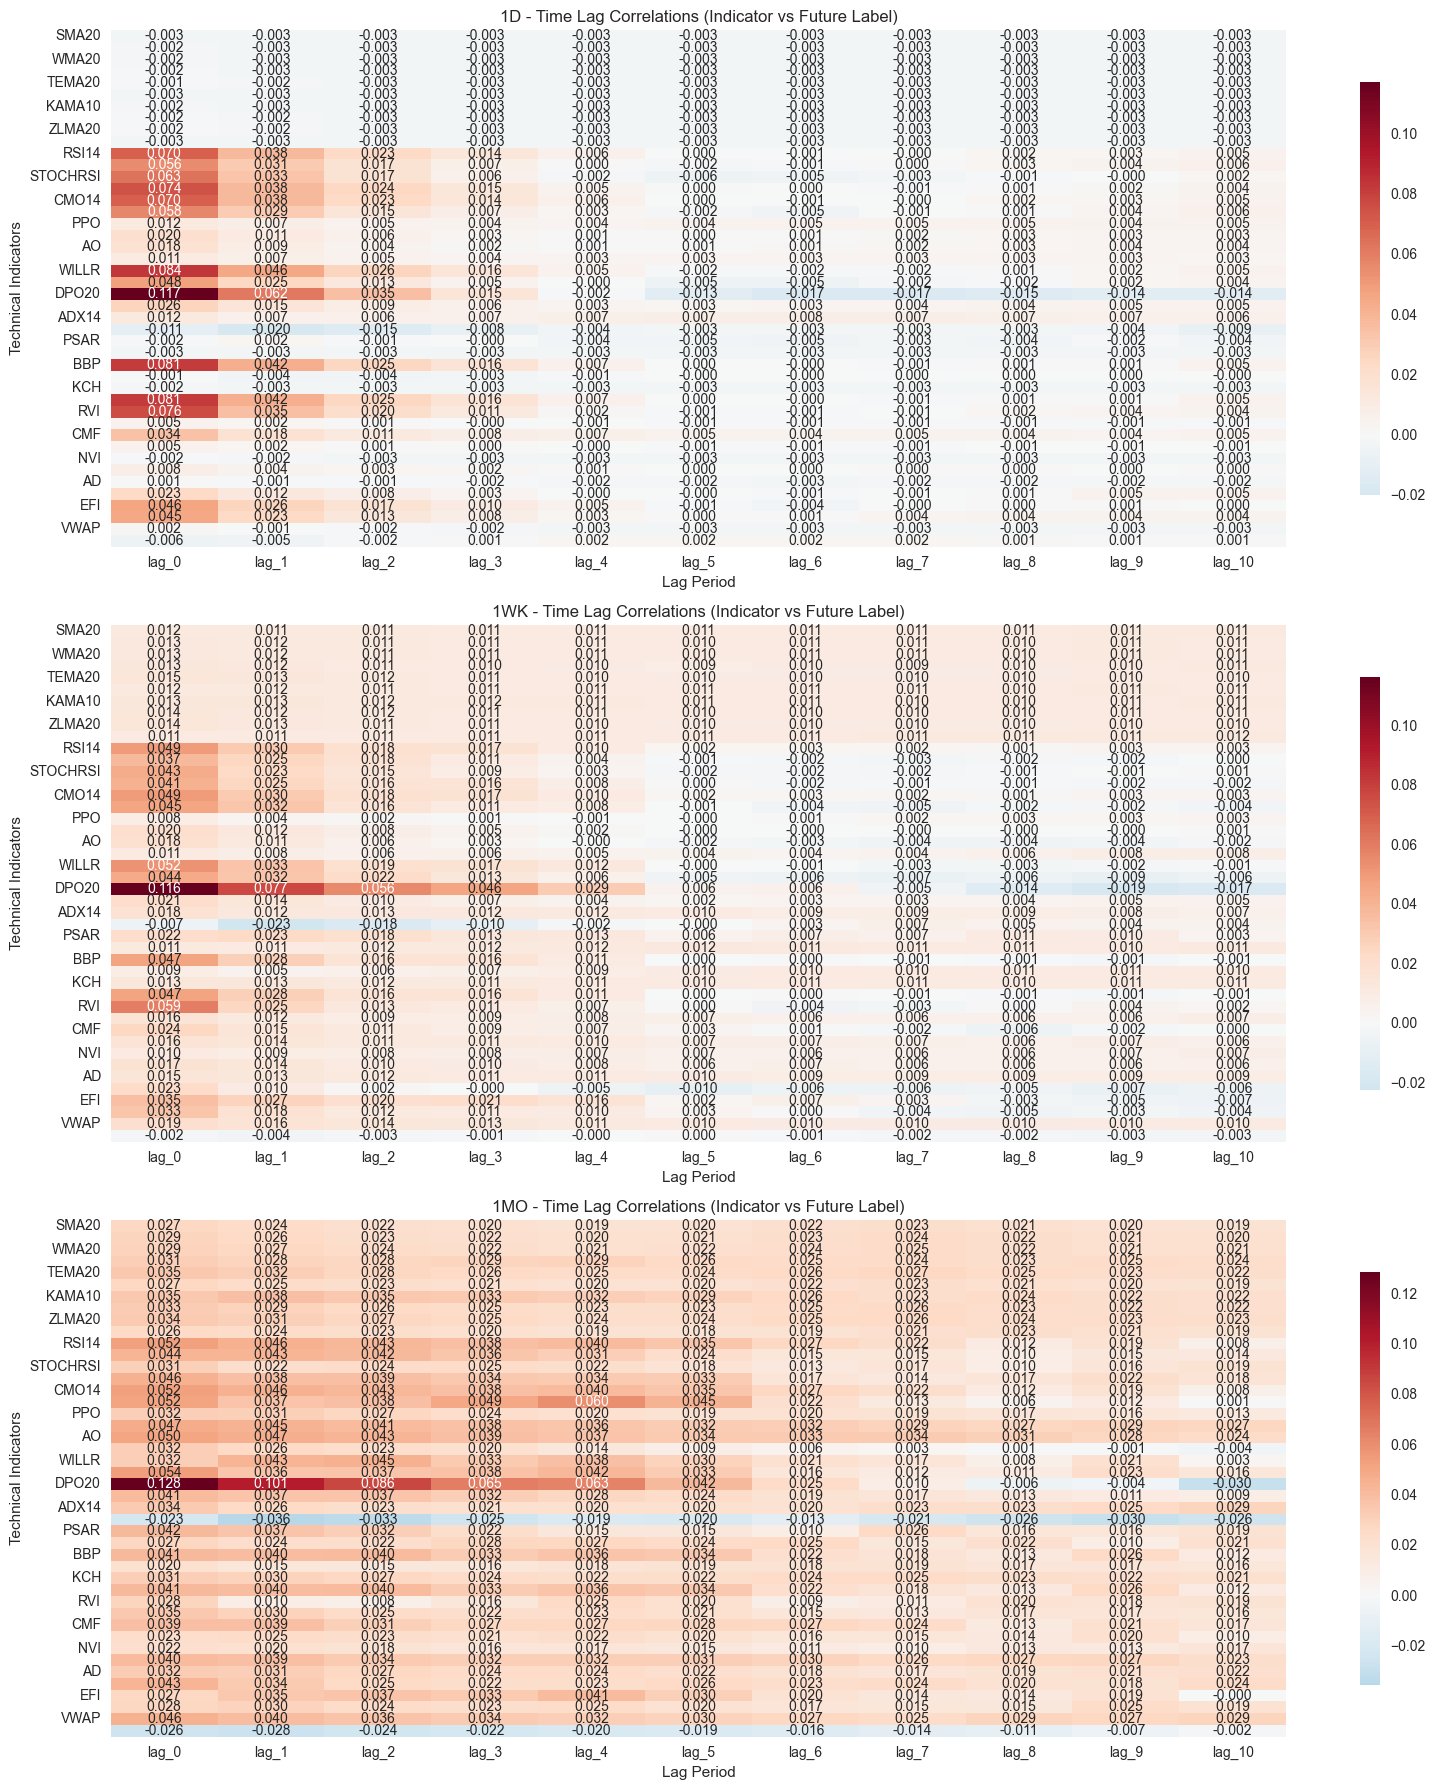

In [ ]:
# Create heatmap visualization for time lag correlations
fig, axes = plt.subplots(len(lag_correlation_results), 1, figsize=(16, 6*len(lag_correlation_results)))
if len(lag_correlation_results) == 1:
    axes = [axes]

for idx, (timeframe, lag_results) in enumerate(lag_correlation_results.items()):
    # Convert to DataFrame
    lag_df = pd.DataFrame(lag_results).T
    lag_df = lag_df.fillna(0)
    
    # Create heatmap
    sns.heatmap(lag_df, annot=True, cmap='RdBu_r', center=0, 
                ax=axes[idx], fmt='.3f', cbar_kws={'shrink': 0.8})
    axes[idx].set_title(f'{timeframe.upper()} - Time Lag Correlations (Indicator vs Future Label)')
    axes[idx].set_xlabel('Lag Period')
    axes[idx].set_ylabel('Technical Indicators')

plt.tight_layout()
plt.show()

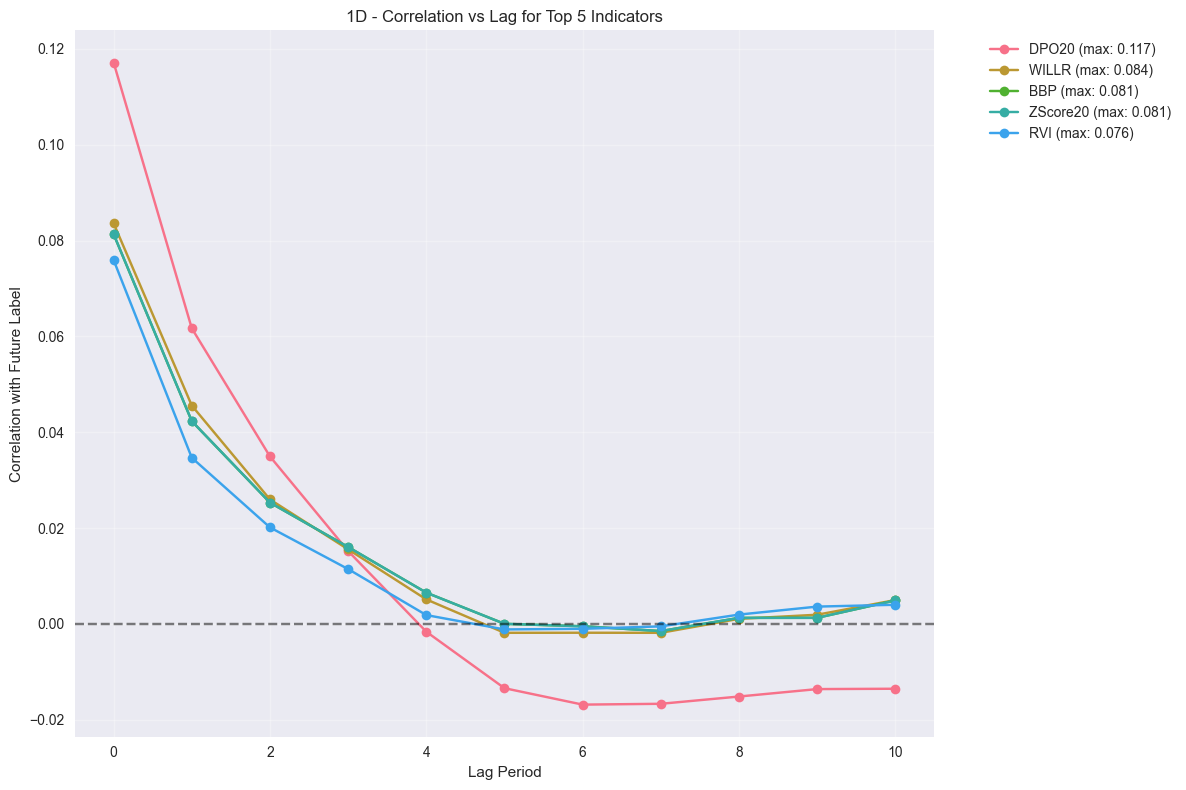

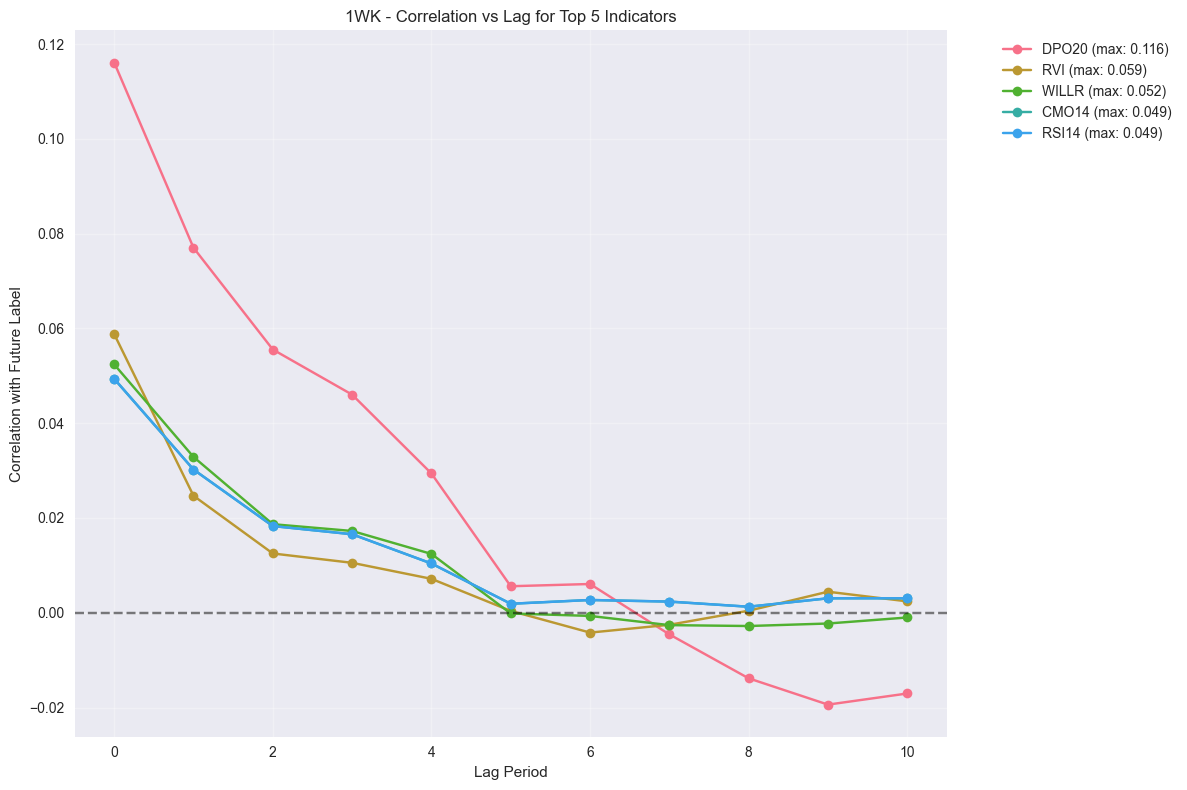

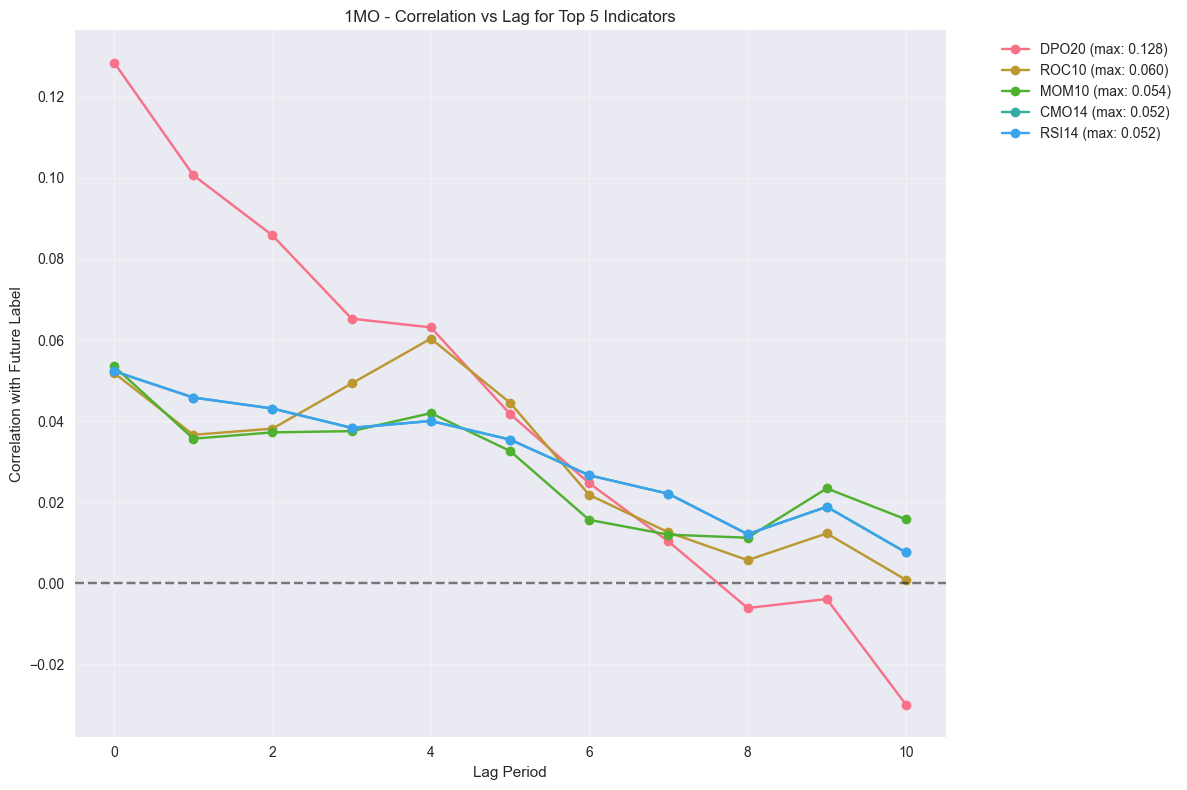

In [ ]:
# Create line plots showing how correlation changes with lag for top indicators
for timeframe, lag_results in lag_correlation_results.items():
    lag_df = pd.DataFrame(lag_results).T
    lag_df = lag_df.fillna(0)
    
    # Find top 5 indicators with highest max absolute correlation
    max_abs_corr = lag_df.abs().max(axis=1).sort_values(ascending=False)
    top_indicators = max_abs_corr.head(5).index
    
    # Create plot
    plt.figure(figsize=(12, 8))
    
    for indicator in top_indicators:
        lags = [int(col.split('_')[1]) for col in lag_df.columns]
        correlations = lag_df.loc[indicator].values
        plt.plot(lags, correlations, marker='o', label=f'{indicator} (max: {max_abs_corr[indicator]:.3f})')
    
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    plt.xlabel('Lag Period')
    plt.ylabel('Correlation with Future Label')
    plt.title(f'{timeframe.upper()} - Correlation vs Lag for Top 5 Indicators')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## Immediate vs Lagged Correlation Comparison

In [ ]:
# Compare immediate correlation (lag 0) with best lagged correlation for each indicator
comparison_results = {}

for timeframe in lag_correlation_results.keys():
    if timeframe in correlation_results:
        lag_df = pd.DataFrame(lag_correlation_results[timeframe]).T
        lag_df = lag_df.fillna(0)
        
        # Get immediate correlations (lag 0) from our lag analysis
        immediate_corr = lag_df['lag_0']
        
        # Get best lagged correlations
        best_lag_corr = lag_df.abs().max(axis=1)
        best_lag_period = lag_df.abs().idxmax(axis=1).apply(lambda x: int(x.split('_')[1]))
        # Get the actual correlation values (with sign) for the best lag periods
        best_lag_corr_signed = pd.Series(index=lag_df.index, dtype=float)
        for idx in lag_df.index:
            best_col = lag_df.abs().idxmax(axis=1)[idx]
            best_lag_corr_signed[idx] = lag_df.loc[idx, best_col]
        
        # Create comparison dataframe
        comparison_df = pd.DataFrame({
            'Immediate_Correlation': immediate_corr,
            'Best_Lag_Correlation': best_lag_corr_signed,
            'Best_Lag_Period': best_lag_period,
            'Improvement': best_lag_corr - immediate_corr.abs(),
            'Improvement_Ratio': best_lag_corr / immediate_corr.abs()
        })
        
        comparison_results[timeframe] = comparison_df
        
        print(f"\n{'='*70}")
        print(f"IMMEDIATE VS LAGGED CORRELATION COMPARISON - {timeframe.upper()}")
        print(f"{'='*70}")
        
        # Sort by improvement
        sorted_comparison = comparison_df.sort_values('Improvement', ascending=False)
        print("\nIndicators with Most Improvement from Lagging:")
        print(sorted_comparison[['Immediate_Correlation', 'Best_Lag_Correlation', 
                                'Best_Lag_Period', 'Improvement']].round(4))
        
        # Indicators where lagging helps significantly
        significant_improvement = sorted_comparison[sorted_comparison['Improvement'] > 0.05]
        if len(significant_improvement) > 0:
            print(f"\nIndicators with Significant Improvement (>0.05):")
            for indicator in significant_improvement.index:
                row = significant_improvement.loc[indicator]
                print(f"  {indicator}: {row['Immediate_Correlation']:.4f} → {row['Best_Lag_Correlation']:.4f} "
                      f"(lag {row['Best_Lag_Period']}, +{row['Improvement']:.4f})")
        else:
            print("\nNo indicators show significant improvement with lagging.")


IMMEDIATE VS LAGGED CORRELATION COMPARISON - 1D

Indicators with Most Improvement from Lagging:
          Immediate_Correlation  Best_Lag_Correlation  Best_Lag_Period  \
AROONOSC                -0.0111               -0.0201                1   
ATR14                   -0.0006               -0.0041                1   
PSAR                    -0.0019               -0.0047                6   
TEMA20                  -0.0010               -0.0032                5   
AD                       0.0006               -0.0025                6   
VWAP                     0.0015               -0.0033                5   
ZLMA20                  -0.0015               -0.0032                5   
NVI                     -0.0018               -0.0034                7   
DEMA20                  -0.0016               -0.0032                5   
HMA20                   -0.0018               -0.0033                4   
KAMA10                  -0.0020               -0.0031                6   
KCH            

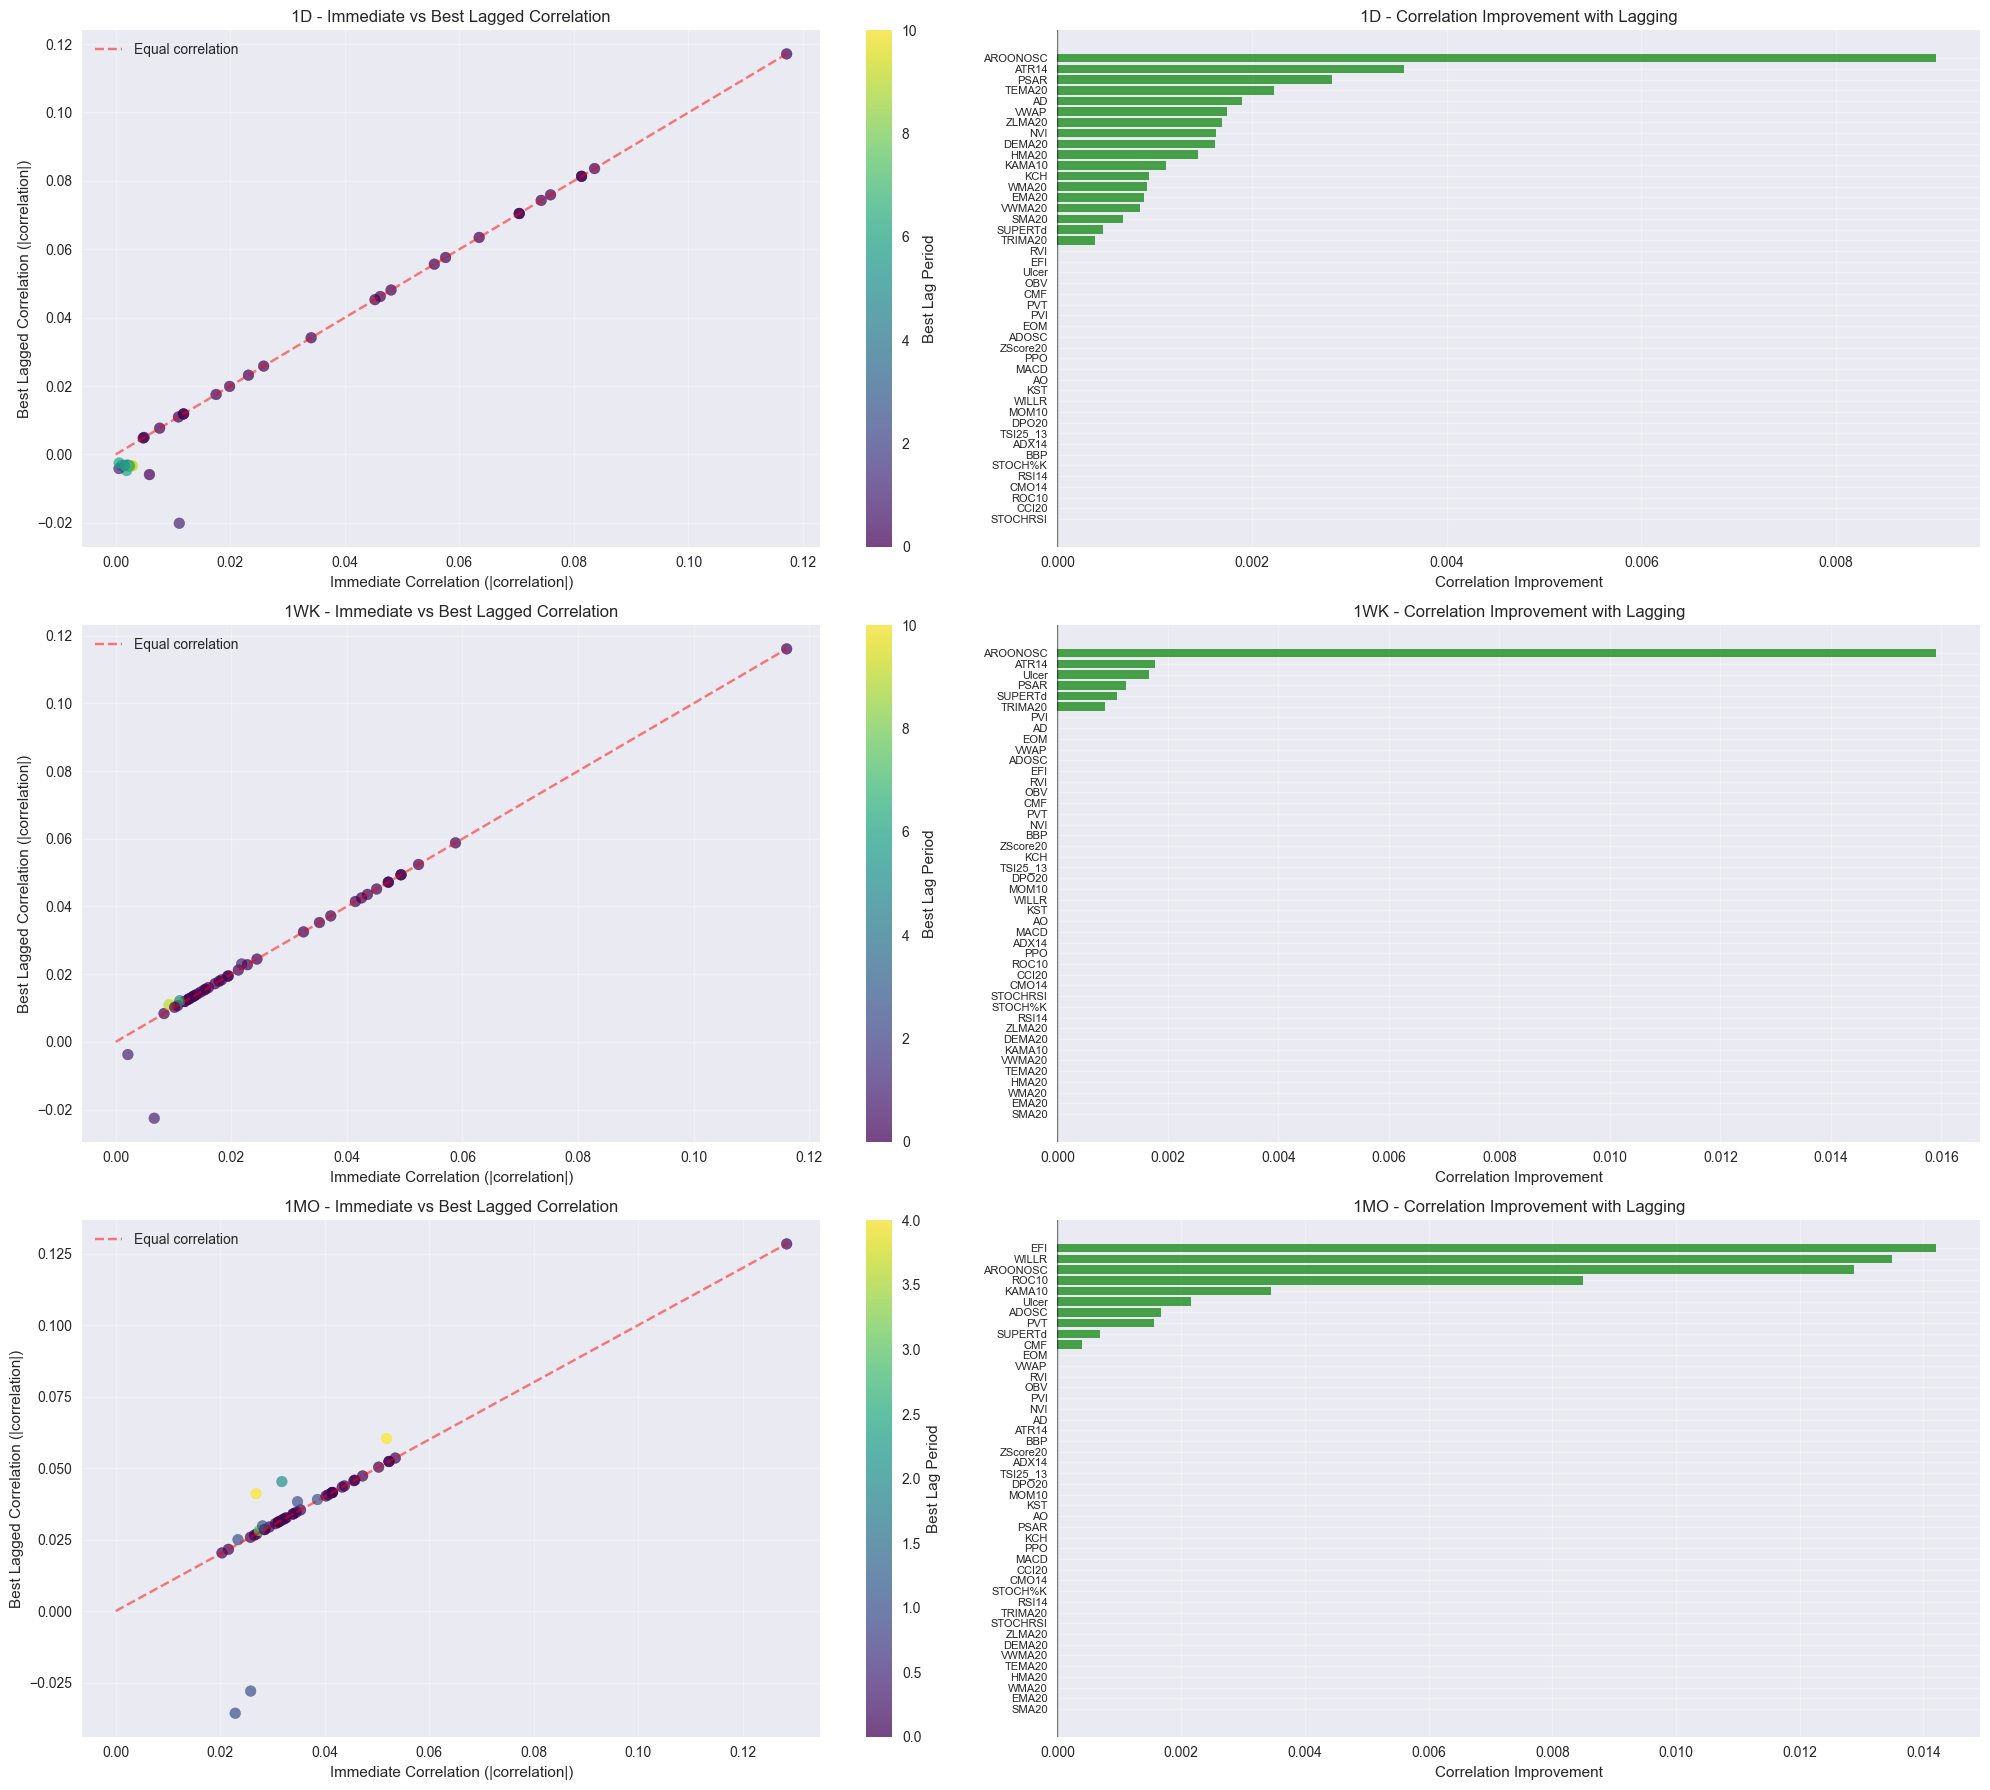

In [ ]:
# Visualize immediate vs best lagged correlations
fig, axes = plt.subplots(len(comparison_results), 2, figsize=(20, 6*len(comparison_results)))
if len(comparison_results) == 1:
    axes = axes.reshape(1, -1)

for idx, (timeframe, comparison_df) in enumerate(comparison_results.items()):
    # Scatter plot: Immediate vs Best Lagged Correlation
    ax1 = axes[idx, 0]
    scatter = ax1.scatter(comparison_df['Immediate_Correlation'].abs(), 
                         comparison_df['Best_Lag_Correlation'],
                         c=comparison_df['Best_Lag_Period'], 
                         cmap='viridis', alpha=0.7, s=60)
    
    # Add diagonal line for reference
    max_val = max(comparison_df['Immediate_Correlation'].abs().max(), 
                  comparison_df['Best_Lag_Correlation'].max())
    ax1.plot([0, max_val], [0, max_val], 'r--', alpha=0.5, label='Equal correlation')
    
    ax1.set_xlabel('Immediate Correlation (|correlation|)')
    ax1.set_ylabel('Best Lagged Correlation (|correlation|)')
    ax1.set_title(f'{timeframe.upper()} - Immediate vs Best Lagged Correlation')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Add colorbar for lag period
    cbar = plt.colorbar(scatter, ax=ax1)
    cbar.set_label('Best Lag Period')
    
    # Bar plot: Improvement by indicator
    ax2 = axes[idx, 1]
    improvement_sorted = comparison_df['Improvement'].sort_values(ascending=True)
    colors = ['red' if x < 0 else 'green' for x in improvement_sorted.values]
    bars = ax2.barh(range(len(improvement_sorted)), improvement_sorted.values, color=colors, alpha=0.7)
    ax2.set_yticks(range(len(improvement_sorted)))
    ax2.set_yticklabels(improvement_sorted.index, fontsize=8)
    ax2.set_xlabel('Correlation Improvement')
    ax2.set_title(f'{timeframe.upper()} - Correlation Improvement with Lagging')
    ax2.axvline(x=0, color='black', linestyle='-', alpha=0.5)
    ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Label2 Time Lag Correlation Analysis

This section analyzes correlations between technical indicators and Label2 (next-day return) with different time lags.

In [ ]:
# Function to calculate time lag correlations for Label2
def calculate_time_lag_correlations_label2(df, max_lag=10):
    """
    Calculate correlations between technical indicators and Label2 with different time lags.
    
    Parameters:
    df: DataFrame with technical indicators and Label2
    max_lag: Maximum number of periods to lag (default: 10)
    
    Returns:
    Dictionary with lag correlations for each indicator
    """
    if 'Label2' not in df.columns:
        return None
        
    # Sort by Symbol and Date to ensure proper time ordering
    df_sorted = df.sort_values(['Symbol', 'Date']).reset_index(drop=True)
    
    # Available technical indicators
    available_indicators = [ind for ind in technical_indicators if ind in df.columns]
    
    lag_correlations = {}
    
    for indicator in available_indicators:
        indicator_lag_corr = {}
        
        # For each lag from 0 to max_lag
        for lag in range(0, max_lag + 1):
            correlations_by_symbol = []
            
            # Calculate correlation for each symbol separately
            for symbol in df['Symbol'].unique():
                symbol_data = df_sorted[df_sorted['Symbol'] == symbol].copy()
                
                if len(symbol_data) <= lag:
                    continue
                
                # Create lagged indicator values
                if lag == 0:
                    indicator_values = symbol_data[indicator].values
                    label2_values = symbol_data['Label2'].values
                else:
                    # Indicator values from lag periods before
                    indicator_values = symbol_data[indicator].iloc[:-lag].values
                    # Current Label2 values
                    label2_values = symbol_data['Label2'].iloc[lag:].values
                
                # Ensure arrays have the same length
                min_length = min(len(indicator_values), len(label2_values))
                indicator_values = indicator_values[:min_length]
                label2_values = label2_values[:min_length]
                
                # Calculate correlation if we have enough data points
                if len(indicator_values) >= 10 and len(label2_values) >= 10:
                    # Remove any NaN values
                    valid_idx = ~(pd.isna(indicator_values) | pd.isna(label2_values))
                    if valid_idx.sum() >= 10:
                        clean_indicator = indicator_values[valid_idx]
                        clean_label2 = label2_values[valid_idx]
                        
                        # Check if we still have enough data and variance
                        if len(clean_indicator) >= 10 and np.var(clean_indicator) > 1e-10 and np.var(clean_label2) > 1e-10:
                            corr = np.corrcoef(clean_indicator, clean_label2)[0, 1]
                            if not np.isnan(corr):
                                correlations_by_symbol.append(corr)
            
            # Average correlation across all symbols for this lag
            if correlations_by_symbol:
                indicator_lag_corr[f'lag_{lag}'] = np.mean(correlations_by_symbol)
            else:
                indicator_lag_corr[f'lag_{lag}'] = np.nan
        
        lag_correlations[indicator] = indicator_lag_corr
    
    return lag_correlations

# Calculate Label2 time lag correlations for all timeframes
lag_correlation_label2_results = {}
for timeframe, df in data_dict.items():
    if df is not None:
        print(f"Calculating Label2 time lag correlations for {timeframe}...")
        lag_corr = calculate_time_lag_correlations_label2(df, max_lag=10)
        if lag_corr is not None:
            lag_correlation_label2_results[timeframe] = lag_corr
            print(f"Completed {timeframe}")
        else:
            print(f"Label2 not found in {timeframe} data")

print("\nLabel2 time lag correlation analysis completed for all timeframes.")

Calculating Label2 time lag correlations for 1d...
Completed 1d
Calculating Label2 time lag correlations for 1wk...
Completed 1d
Calculating Label2 time lag correlations for 1wk...
Completed 1wk
Calculating Label2 time lag correlations for 1mo...
Completed 1wk
Calculating Label2 time lag correlations for 1mo...
Completed 1mo

Label2 time lag correlation analysis completed for all timeframes.
Completed 1mo

Label2 time lag correlation analysis completed for all timeframes.


In [ ]:
# Display Label2 time lag correlation results
for timeframe, lag_results in lag_correlation_label2_results.items():
    print(f"\n{'='*70}")
    print(f"LABEL2 TIME LAG CORRELATION ANALYSIS - {timeframe.upper()}")
    print(f"{'='*70}")
    
    # Convert to DataFrame for easier analysis
    lag_df = pd.DataFrame(lag_results).T
    lag_df = lag_df.fillna(0)  # Fill NaN with 0 for display
    
    print(f"\nTime Lag Correlations (Indicator vs Future Label2):")
    print(lag_df.round(4))
    
    # Find best lag for each indicator
    print(f"\nBest Lag Period for Each Indicator (Label2):")
    for indicator in lag_df.index:
        best_lag_col = lag_df.loc[indicator].abs().idxmax()
        best_correlation = lag_df.loc[indicator, best_lag_col]
        best_lag = int(best_lag_col.split('_')[1])
        print(f"  {indicator}: Lag {best_lag} periods (correlation: {best_correlation:.4f})")
    
    # Find indicators with strongest lag correlations for Label2
    print(f"\nStrongest Label2 Lag Correlations:")
    max_abs_corr_per_indicator = lag_df.abs().max(axis=1).sort_values(ascending=False)
    for indicator in max_abs_corr_per_indicator.head(5).index:
        best_lag_col = lag_df.loc[indicator].abs().idxmax()
        best_correlation = lag_df.loc[indicator, best_lag_col]
        best_lag = int(best_lag_col.split('_')[1])
        print(f"  {indicator}: {best_correlation:.4f} at lag {best_lag}")


LABEL2 TIME LAG CORRELATION ANALYSIS - 1D

Time Lag Correlations (Indicator vs Future Label2):
           lag_0   lag_1   lag_2   lag_3   lag_4   lag_5   lag_6   lag_7  \
SMA20    -0.0460 -0.0453 -0.0445 -0.0438 -0.0432 -0.0425 -0.0419 -0.0413   
EMA20    -0.0467 -0.0459 -0.0450 -0.0444 -0.0437 -0.0431 -0.0424 -0.0418   
WMA20    -0.0483 -0.0474 -0.0466 -0.0458 -0.0452 -0.0444 -0.0437 -0.0431   
HMA20    -0.0522 -0.0513 -0.0505 -0.0496 -0.0488 -0.0479 -0.0471 -0.0463   
TEMA20   -0.0529 -0.0519 -0.0509 -0.0501 -0.0493 -0.0484 -0.0476 -0.0468   
VWMA20   -0.0472 -0.0464 -0.0455 -0.0448 -0.0442 -0.0435 -0.0428 -0.0422   
KAMA10   -0.0497 -0.0490 -0.0482 -0.0474 -0.0465 -0.0458 -0.0451 -0.0445   
DEMA20   -0.0518 -0.0508 -0.0498 -0.0490 -0.0483 -0.0475 -0.0467 -0.0459   
ZLMA20   -0.0523 -0.0514 -0.0504 -0.0495 -0.0487 -0.0478 -0.0470 -0.0462   
TRIMA20  -0.0462 -0.0454 -0.0447 -0.0439 -0.0432 -0.0426 -0.0420 -0.0414   
RSI14    -0.1345 -0.1298 -0.1243 -0.1215 -0.1154 -0.1144 -0.1107 -0.

## Label vs Label2 Time Lag Comparison

Compare how indicators perform across different lags for Label vs Label2.

In [ ]:
# Compare Label vs Label2 time lag correlations
lag_comparison_results = {}

for timeframe in lag_correlation_results.keys():
    if timeframe in lag_correlation_label2_results:
        label_lag_df = pd.DataFrame(lag_correlation_results[timeframe]).T.fillna(0)
        label2_lag_df = pd.DataFrame(lag_correlation_label2_results[timeframe]).T.fillna(0)
        
        # Get best correlations for each indicator
        label_best = label_lag_df.abs().max(axis=1)
        label2_best = label2_lag_df.abs().max(axis=1)
        
        # Get best lag periods
        label_best_lag = label_lag_df.abs().idxmax(axis=1).apply(lambda x: int(x.split('_')[1]))
        label2_best_lag = label2_lag_df.abs().idxmax(axis=1).apply(lambda x: int(x.split('_')[1]))
        
        # Create comparison dataframe
        lag_comparison_df = pd.DataFrame({
            'Label_Best_Correlation': label_best,
            'Label_Best_Lag': label_best_lag,
            'Label2_Best_Correlation': label2_best,
            'Label2_Best_Lag': label2_best_lag,
            'Correlation_Difference': label2_best - label_best,
            'Lag_Difference': label2_best_lag - label_best_lag
        })
        
        lag_comparison_results[timeframe] = lag_comparison_df
        
        print(f"\n{'='*80}")
        print(f"LABEL vs LABEL2 TIME LAG COMPARISON - {timeframe.upper()}")
        print(f"{'='*80}")
        
        # Indicators where Label2 lag correlation is significantly better
        better_label2 = lag_comparison_df[lag_comparison_df['Correlation_Difference'] > 0.05].sort_values('Correlation_Difference', ascending=False)
        
        print(f"\nIndicators with stronger Label2 lag correlation (difference > 0.05):")
        if len(better_label2) > 0:
            for indicator in better_label2.head(10).index:
                row = better_label2.loc[indicator]
                print(f"  {indicator}: Label={row['Label_Best_Correlation']:.3f}@lag{row['Label_Best_Lag']}, "
                      f"Label2={row['Label2_Best_Correlation']:.3f}@lag{row['Label2_Best_Lag']} "
                      f"(diff: +{row['Correlation_Difference']:.3f})")
        else:
            print("  No indicators show significantly stronger Label2 lag correlation")
        
        # Indicators where Label lag correlation is significantly better
        better_label = lag_comparison_df[lag_comparison_df['Correlation_Difference'] < -0.05].sort_values('Correlation_Difference', ascending=True)
        
        print(f"\nIndicators with stronger Label lag correlation (difference < -0.05):")
        if len(better_label) > 0:
            for indicator in better_label.head(10).index:
                row = better_label.loc[indicator]
                print(f"  {indicator}: Label={row['Label_Best_Correlation']:.3f}@lag{row['Label_Best_Lag']}, "
                      f"Label2={row['Label2_Best_Correlation']:.3f}@lag{row['Label2_Best_Lag']} "
                      f"(diff: {row['Correlation_Difference']:.3f})")
        else:
            print("  No indicators show significantly stronger Label lag correlation")
        
        # Summary statistics
        print(f"\nSummary Statistics:")
        print(f"  Mean Label best correlation: {lag_comparison_df['Label_Best_Correlation'].mean():.3f}")
        print(f"  Mean Label2 best correlation: {lag_comparison_df['Label2_Best_Correlation'].mean():.3f}")
        print(f"  Mean correlation difference (Label2 - Label): {lag_comparison_df['Correlation_Difference'].mean():.3f}")
        print(f"  Mean Label best lag: {lag_comparison_df['Label_Best_Lag'].mean():.1f}")
        print(f"  Mean Label2 best lag: {lag_comparison_df['Label2_Best_Lag'].mean():.1f}")
    else:
        print(f"\nLabel2 time lag data not available for {timeframe} - skipping comparison")


LABEL vs LABEL2 TIME LAG COMPARISON - 1D

Indicators with stronger Label2 lag correlation (difference > 0.05):
  Ulcer: Label=0.006@lag0.0, Label2=0.256@lag0.0 (diff: +0.250)
  ATR14: Label=0.004@lag1.0, Label2=0.141@lag0.0 (diff: +0.136)
  KST: Label=0.011@lag0.0, Label2=0.124@lag0.0 (diff: +0.113)
  TSI25_13: Label=0.026@lag0.0, Label2=0.138@lag0.0 (diff: +0.112)
  PPO: Label=0.012@lag0.0, Label2=0.122@lag0.0 (diff: +0.110)
  MACD: Label=0.020@lag0.0, Label2=0.124@lag0.0 (diff: +0.104)
  AO: Label=0.018@lag0.0, Label2=0.113@lag0.0 (diff: +0.095)
  PVI: Label=0.008@lag0.0, Label2=0.102@lag0.0 (diff: +0.094)
  AROONOSC: Label=0.020@lag1.0, Label2=0.092@lag0.0 (diff: +0.072)
  OBV: Label=0.005@lag0.0, Label2=0.071@lag0.0 (diff: +0.066)

Indicators with stronger Label lag correlation (difference < -0.05):
  DPO20: Label=0.117@lag0.0, Label2=0.065@lag2.0 (diff: -0.052)

Summary Statistics:
  Mean Label best correlation: 0.028
  Mean Label2 best correlation: 0.081
  Mean correlation diffe

In [ ]:
# Display correlation results
for timeframe, results in correlation_results.items():
    print(f"\n{'='*70}")
    print(f"CORRELATION ANALYSIS - {timeframe.upper()}")
    print(f"{'='*70}")
    
    print(f"\nCorrelations with Close Price:")
    close_corr_df = pd.DataFrame({
        'Indicator': results['close_correlations'].index,
        'Correlation': results['close_correlations'].values
    }).sort_values('Correlation', key=abs, ascending=False)
    print(close_corr_df)
    
    print(f"\nCorrelations with Label:")
    label_corr_df = pd.DataFrame({
        'Indicator': results['label_correlations'].index,
        'Correlation': results['label_correlations'].values
    }).sort_values('Correlation', key=abs, ascending=False)
    print(label_corr_df)


CORRELATION ANALYSIS - 1D

Correlations with Close Price:
   Indicator  Correlation
42      VWAP     0.999973
4     TEMA20     0.999592
8     ZLMA20     0.999506
7     DEMA20     0.999399
3      HMA20     0.999396
2      WMA20     0.998966
26      PSAR     0.998960
6     KAMA10     0.998949
1      EMA20     0.998743
30       KCH     0.998657
5     VWMA20     0.998548
0      SMA20     0.998250
9    TRIMA20     0.998092
27   SUPERTd     0.996460
29     ATR14     0.851282
36       NVI     0.667872
17      MACD     0.190193
18        AO     0.156298
21     MOM10     0.095531
39       EOM     0.085448
37       PVI     0.072159
32       RVI     0.066041
23  TSI25_13     0.065459
14     CMO14     0.056642
10     RSI14     0.056642
19       KST     0.054335
35       PVT    -0.053441
43     Ulcer    -0.052916
33       OBV    -0.047373
11   STOCH%K     0.044528
16       PPO     0.043751
20     WILLR     0.041402
28       BBP     0.034101
31  ZScore20     0.034101
13     CCI20     0.033045
25  A

## Visualization: Correlation Heatmaps

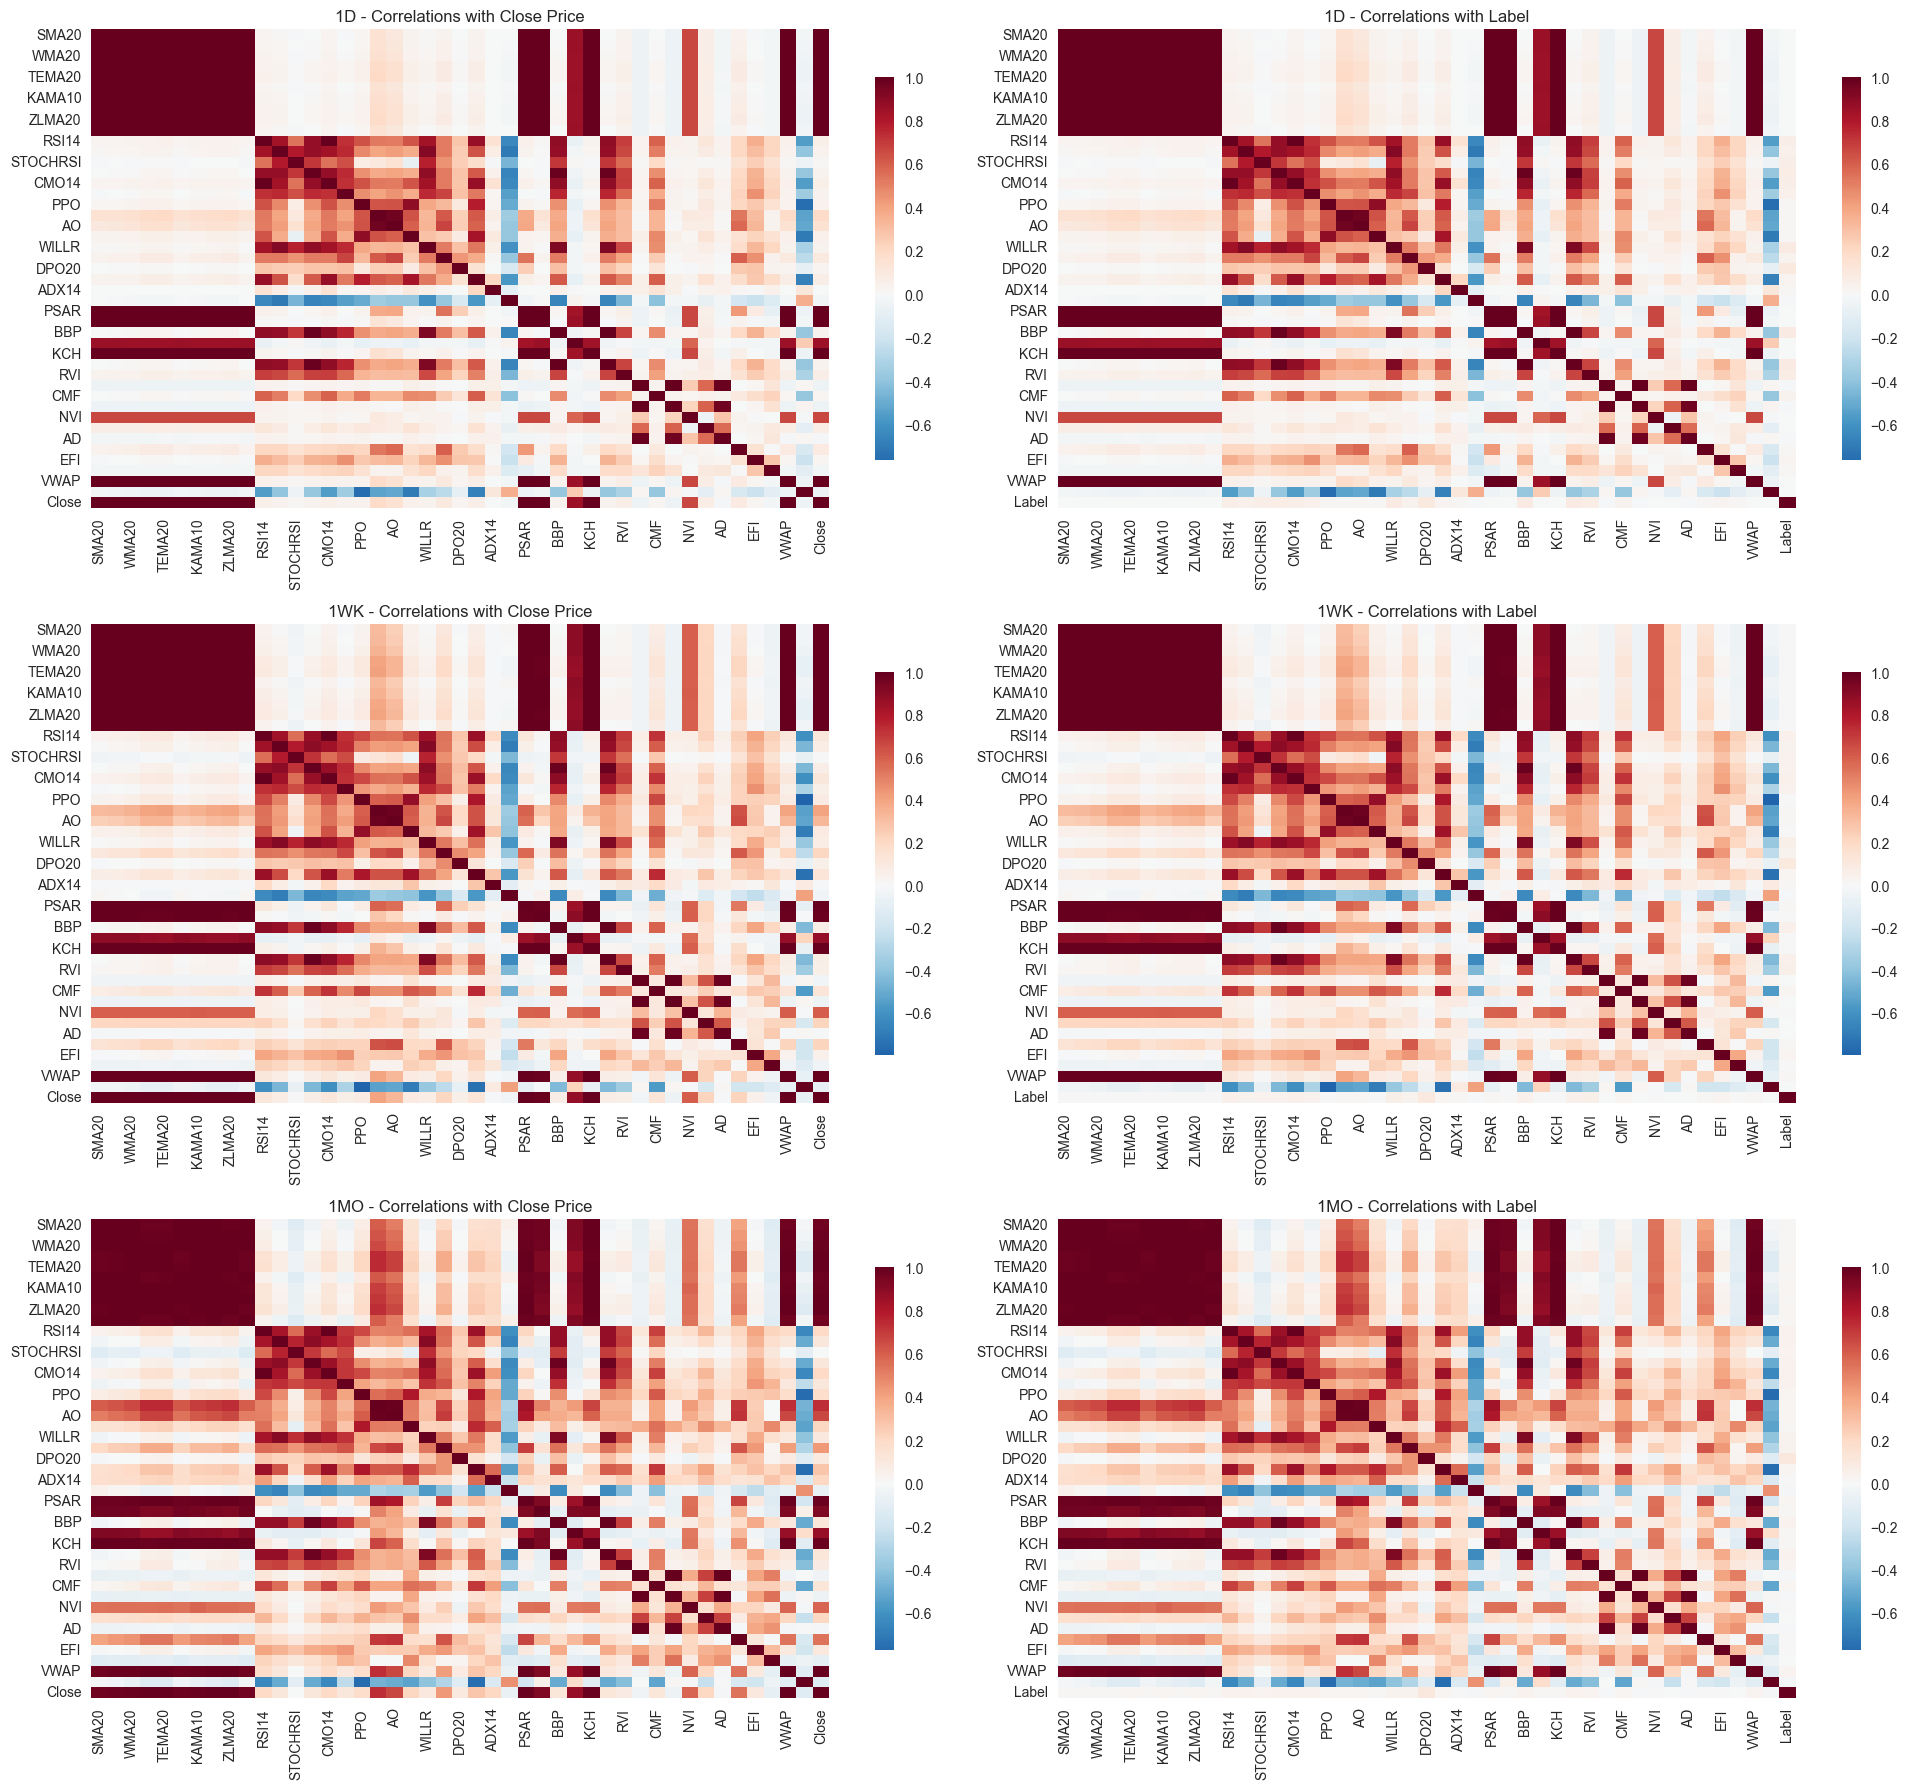

In [ ]:
# Create correlation heatmaps
fig, axes = plt.subplots(len(correlation_results), 2, figsize=(20, 6*len(correlation_results)))
if len(correlation_results) == 1:
    axes = axes.reshape(1, -1)

for idx, (timeframe, results) in enumerate(correlation_results.items()):
    # Get the dataframe for this timeframe
    df = data_dict[timeframe]
    available_indicators = [ind for ind in technical_indicators if ind in df.columns]
    
    # Create correlation matrix for Close price
    close_corr_matrix = df[available_indicators + ['Close']].corr()
    
    # Create correlation matrix for Label
    label_corr_matrix = df[available_indicators + ['Label']].corr()
    
    # Plot Close price correlations
    sns.heatmap(close_corr_matrix, annot=False, cmap='RdBu_r', center=0, 
                ax=axes[idx, 0], cbar_kws={'shrink': 0.8})
    axes[idx, 0].set_title(f'{timeframe.upper()} - Correlations with Close Price')
    
    # Plot Label correlations
    sns.heatmap(label_corr_matrix, annot=False, cmap='RdBu_r', center=0, 
                ax=axes[idx, 1], cbar_kws={'shrink': 0.8})
    axes[idx, 1].set_title(f'{timeframe.upper()} - Correlations with Label')

plt.tight_layout()
plt.show()

## Top Correlated Indicators Analysis

## Mutual Information Analysis

Mutual information captures both linear and non-linear relationships between variables, providing insights beyond correlation analysis. This section analyzes the mutual information between technical indicators and target variables.

In [ ]:
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif
from sklearn.preprocessing import LabelEncoder

# Function to calculate mutual information
def calculate_mutual_information(df, timeframe_name):
    """Calculate mutual information between technical indicators and target variables."""
    
    # Ensure all required columns exist
    available_indicators = [ind for ind in technical_indicators if ind in df.columns]
    
    if 'Close' not in df.columns or 'Label' not in df.columns:
        print(f"Missing Close or Label columns in {timeframe_name}")
        return None, None
    
    # Prepare data - remove NaN values
    clean_df = df[available_indicators + ['Close', 'Label']].dropna()
    
    if len(clean_df) < 50:  # Need sufficient data for MI calculation
        print(f"Insufficient data for mutual information in {timeframe_name}")
        return None, None
    
    X = clean_df[available_indicators]
    y_close = clean_df['Close']
    y_label = clean_df['Label']
    
    # Calculate mutual information with Close price (regression)
    mi_close = mutual_info_regression(X, y_close, random_state=42, n_neighbors=5)
    close_mi_scores = pd.Series(mi_close, index=available_indicators)
    
    # Calculate mutual information with Label (classification)
    # Convert labels to integers if they're not already
    label_encoder = LabelEncoder()
    y_label_encoded = label_encoder.fit_transform(y_label)
    
    mi_label = mutual_info_classif(X, y_label_encoded, random_state=42, n_neighbors=5)
    label_mi_scores = pd.Series(mi_label, index=available_indicators)
    
    return close_mi_scores, label_mi_scores

# Calculate mutual information for all timeframes
mi_results = {}
for timeframe, df in data_dict.items():
    if df is not None:
        print(f"Calculating mutual information for {timeframe}...")
        close_mi, label_mi = calculate_mutual_information(df, timeframe)
        if close_mi is not None and label_mi is not None:
            mi_results[timeframe] = {
                'close_mi': close_mi,
                'label_mi': label_mi
            }
            print(f"Completed {timeframe}")

print("\nMutual information analysis completed for all timeframes.")

Calculating mutual information for 1d...
Completed 1d
Calculating mutual information for 1wk...
Completed 1d
Calculating mutual information for 1wk...
Completed 1wk
Calculating mutual information for 1mo...
Completed 1wk
Calculating mutual information for 1mo...
Completed 1mo

Mutual information analysis completed for all timeframes.
Completed 1mo

Mutual information analysis completed for all timeframes.


In [ ]:
# Display mutual information results
for timeframe, results in mi_results.items():
    print(f"\n{'='*70}")
    print(f"MUTUAL INFORMATION ANALYSIS - {timeframe.upper()}")
    print(f"{'='*70}")
    
    print(f"\nMutual Information with Close Price:")
    close_mi_df = pd.DataFrame({
        'Indicator': results['close_mi'].index,
        'Mutual_Information': results['close_mi'].values
    }).sort_values('Mutual_Information', ascending=False)
    print(close_mi_df)
    
    print(f"\nMutual Information with Label:")
    label_mi_df = pd.DataFrame({
        'Indicator': results['label_mi'].index,
        'Mutual_Information': results['label_mi'].values
    }).sort_values('Mutual_Information', ascending=False)
    print(label_mi_df)
    
    # Top 10 indicators by mutual information
    print(f"\nTop 10 indicators by MI with Close Price:")
    for indicator in close_mi_df.head(10)['Indicator']:
        mi_score = results['close_mi'][indicator]
        print(f"  {indicator}: {mi_score:.4f}")
    
    print(f"\nTop 10 indicators by MI with Label:")
    for indicator in label_mi_df.head(10)['Indicator']:
        mi_score = results['label_mi'][indicator]
        print(f"  {indicator}: {mi_score:.4f}")


MUTUAL INFORMATION ANALYSIS - 1D

Mutual Information with Close Price:
   Indicator  Mutual_Information
42      VWAP            5.307127
4     TEMA20            4.058219
8     ZLMA20            4.003069
7     DEMA20            3.983188
3      HMA20            3.854674
6     KAMA10            3.831251
2      WMA20            3.815184
1      EMA20            3.664151
5     VWMA20            3.560395
26      PSAR            3.547957
9    TRIMA20            3.522522
0      SMA20            3.514709
30       KCH            3.440415
27   SUPERTd            3.215742
36       NVI            1.247850
38        AD            1.076131
29     ATR14            1.018926
35       PVT            0.993749
37       PVI            0.957038
33       OBV            0.922467
39       EOM            0.692999
17      MACD            0.455128
18        AO            0.407613
21     MOM10            0.355293
22     DPO20            0.299573
41     ADOSC            0.171337
43     Ulcer            0.111991
19  

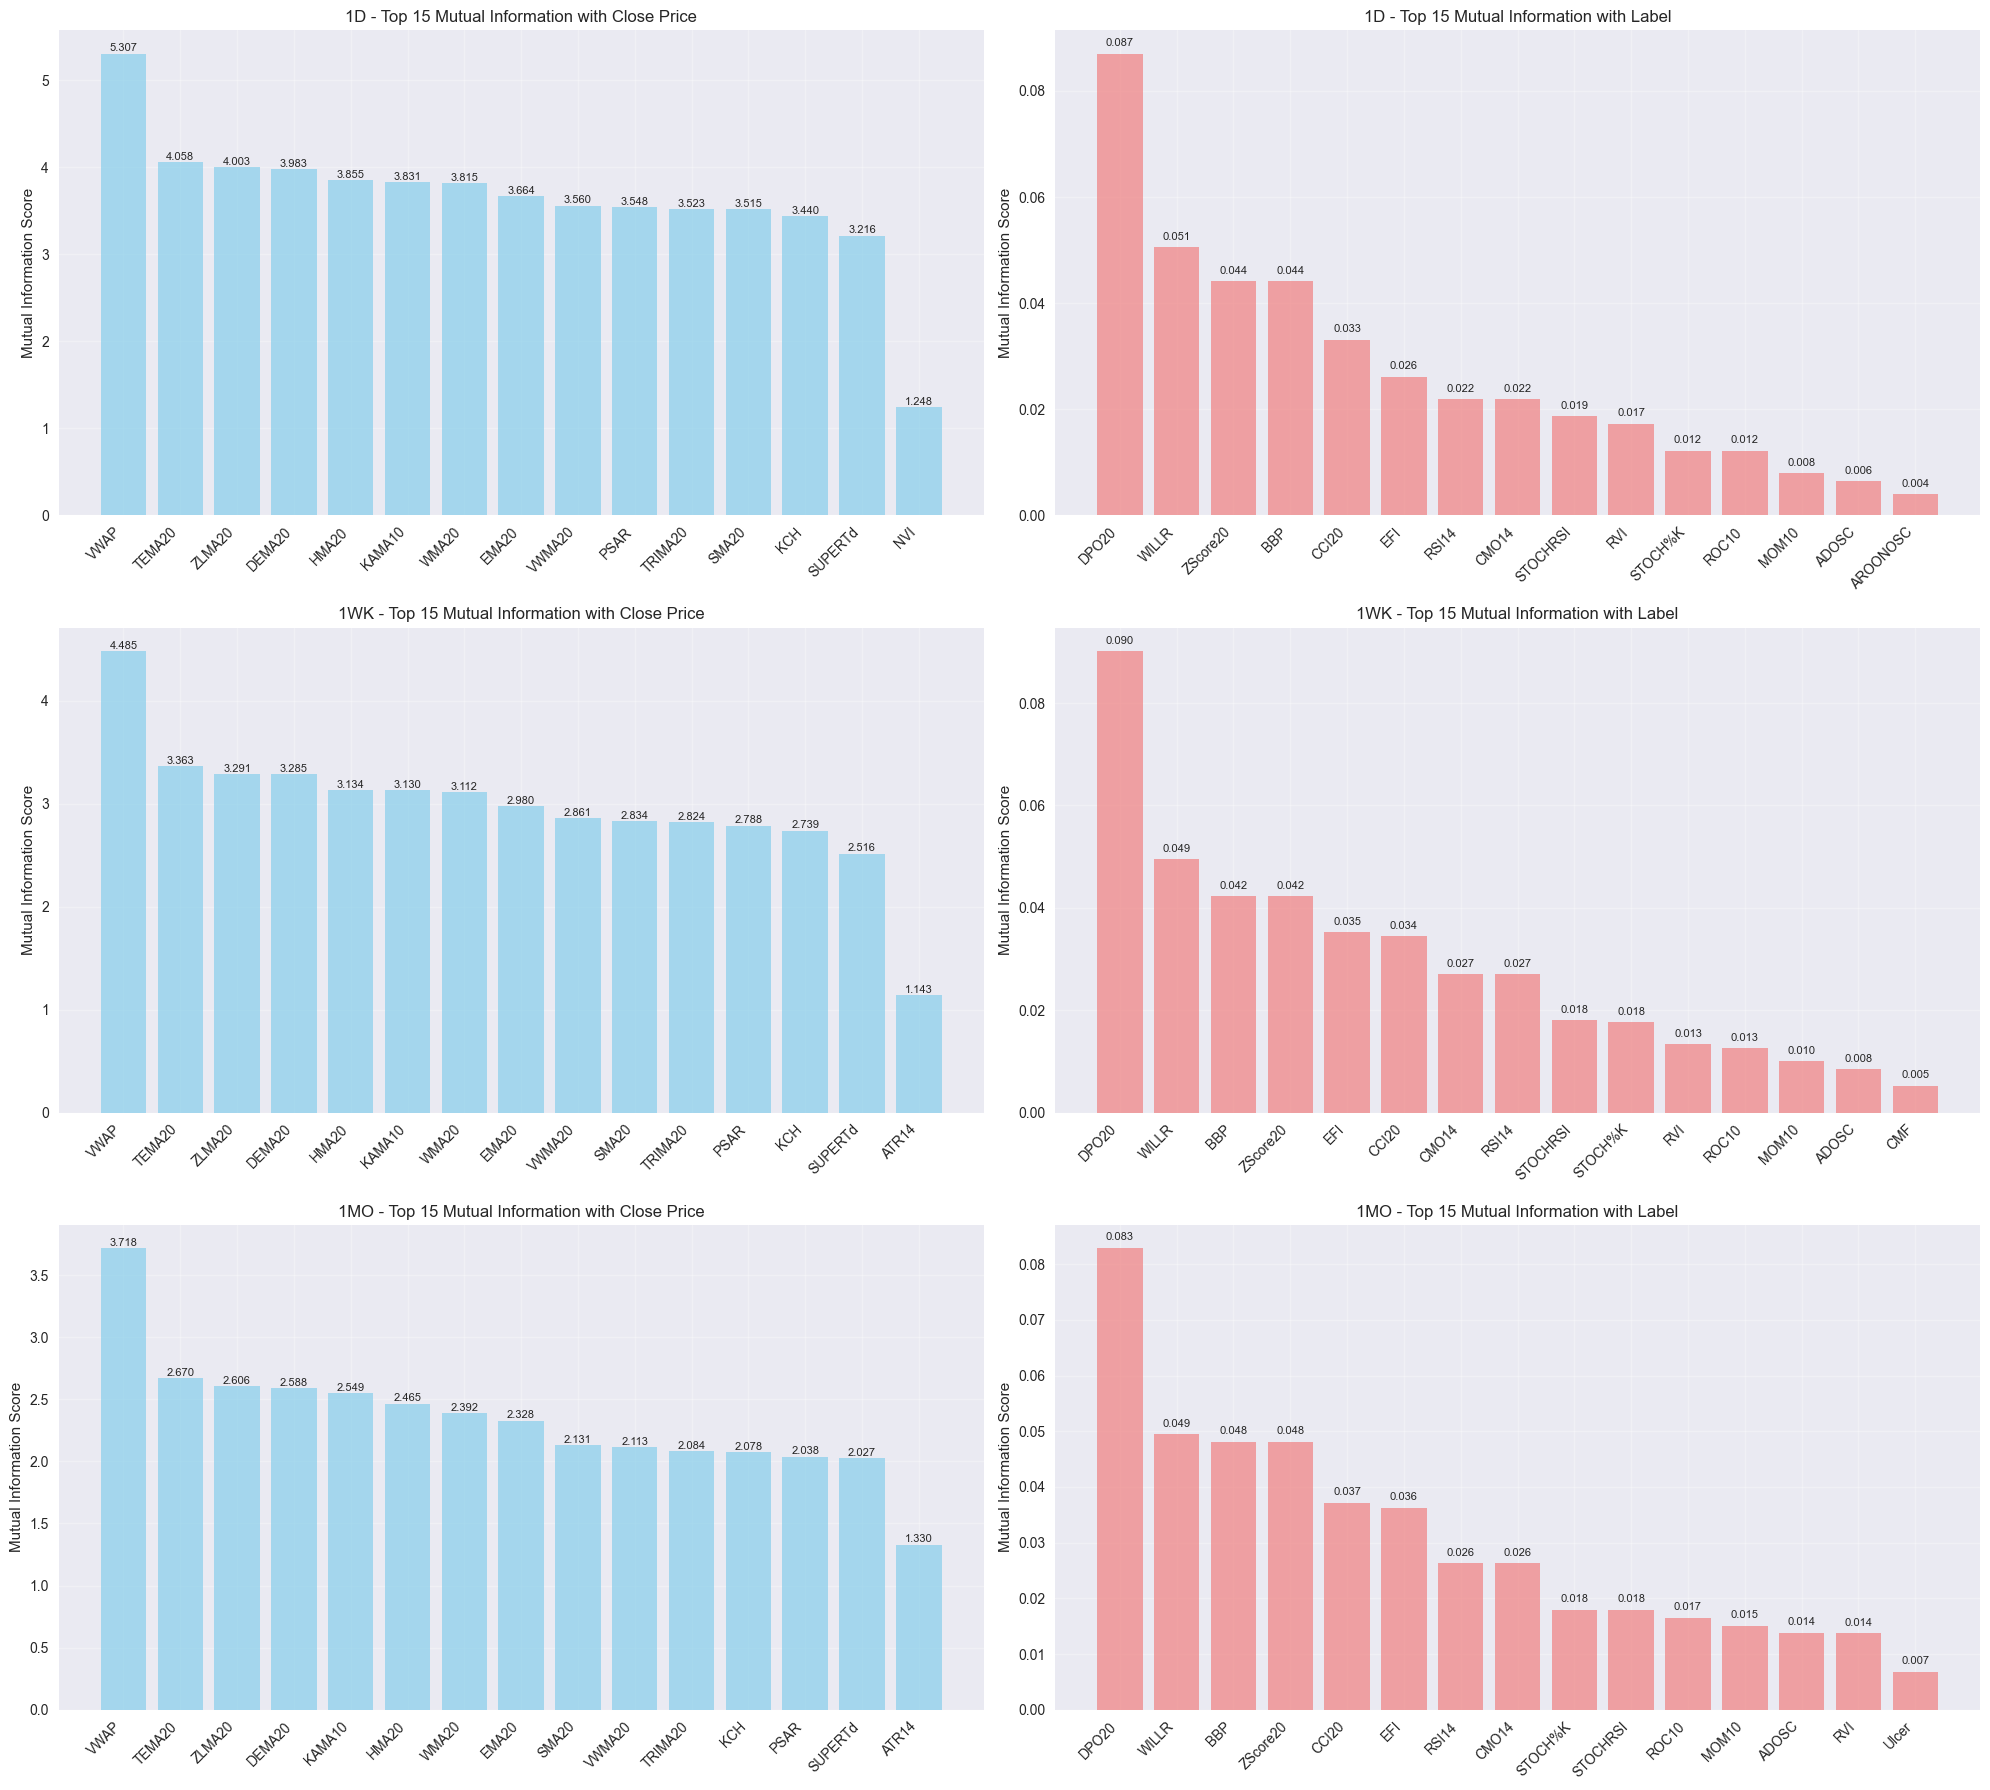

In [ ]:
# Visualize mutual information results
fig, axes = plt.subplots(len(mi_results), 2, figsize=(20, 6*len(mi_results)))
if len(mi_results) == 1:
    axes = axes.reshape(1, -1)

for idx, (timeframe, results) in enumerate(mi_results.items()):
    # Top 15 indicators for Close price MI
    top_close_mi = results['close_mi'].nlargest(15)
    ax1 = axes[idx, 0]
    bars1 = ax1.bar(range(len(top_close_mi)), top_close_mi.values, color='skyblue', alpha=0.7)
    ax1.set_title(f'{timeframe.upper()} - Top 15 Mutual Information with Close Price')
    ax1.set_ylabel('Mutual Information Score')
    ax1.set_xticks(range(len(top_close_mi)))
    ax1.set_xticklabels(top_close_mi.index, rotation=45, ha='right')
    ax1.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, (bar, value) in enumerate(zip(bars1, top_close_mi.values)):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                f'{value:.3f}', ha='center', va='bottom', fontsize=8)
    
    # Top 15 indicators for Label MI
    top_label_mi = results['label_mi'].nlargest(15)
    ax2 = axes[idx, 1]
    bars2 = ax2.bar(range(len(top_label_mi)), top_label_mi.values, color='lightcoral', alpha=0.7)
    ax2.set_title(f'{timeframe.upper()} - Top 15 Mutual Information with Label')
    ax2.set_ylabel('Mutual Information Score')
    ax2.set_xticks(range(len(top_label_mi)))
    ax2.set_xticklabels(top_label_mi.index, rotation=45, ha='right')
    ax2.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, (bar, value) in enumerate(zip(bars2, top_label_mi.values)):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                f'{value:.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

In [ ]:
# Compare correlation vs mutual information
comparison_mi_corr = {}

for timeframe in mi_results.keys():
    if timeframe in correlation_results:
        # Get correlation data
        corr_close = correlation_results[timeframe]['close_correlations'].abs()
        corr_label = correlation_results[timeframe]['label_correlations'].abs()
        
        # Get mutual information data
        mi_close = mi_results[timeframe]['close_mi']
        mi_label = mi_results[timeframe]['label_mi']
        
        # Create comparison dataframe
        comparison_df = pd.DataFrame({
            'Correlation_Close': corr_close,
            'MI_Close': mi_close,
            'Correlation_Label': corr_label,
            'MI_Label': mi_label
        }).fillna(0)
        
        comparison_mi_corr[timeframe] = comparison_df
        
        print(f"\n{'='*70}")
        print(f"CORRELATION vs MUTUAL INFORMATION COMPARISON - {timeframe.upper()}")
        print(f"{'='*70}")
        
        # Find indicators where MI reveals more information than correlation
        # Higher MI relative to correlation suggests non-linear relationships
        close_ratio = (comparison_df['MI_Close'] / (comparison_df['Correlation_Close'] + 1e-10))
        label_ratio = (comparison_df['MI_Label'] / (comparison_df['Correlation_Label'] + 1e-10))
        
        print(f"\nIndicators with highest MI/Correlation ratio (Close Price):")
        top_close_ratio = close_ratio.sort_values(ascending=False).head(10)
        for indicator, ratio in top_close_ratio.items():
            corr_val = comparison_df.loc[indicator, 'Correlation_Close']
            mi_val = comparison_df.loc[indicator, 'MI_Close']
            print(f"  {indicator}: Ratio={ratio:.2f}, Corr={corr_val:.4f}, MI={mi_val:.4f}")
        
        print(f"\nIndicators with highest MI/Correlation ratio (Label):")
        top_label_ratio = label_ratio.sort_values(ascending=False).head(10)
        for indicator, ratio in top_label_ratio.items():
            corr_val = comparison_df.loc[indicator, 'Correlation_Label']
            mi_val = comparison_df.loc[indicator, 'MI_Label']
            print(f"  {indicator}: Ratio={ratio:.2f}, Corr={corr_val:.4f}, MI={mi_val:.4f}")


CORRELATION vs MUTUAL INFORMATION COMPARISON - 1D

Indicators with highest MI/Correlation ratio (Close Price):
  AD: Ratio=55.98, Corr=0.0192, MI=1.0761
  OBV: Ratio=19.47, Corr=0.0474, MI=0.9225
  PVT: Ratio=18.60, Corr=0.0534, MI=0.9937
  ADX14: Ratio=13.53, Corr=0.0031, MI=0.0425
  PVI: Ratio=13.26, Corr=0.0722, MI=0.9570
  DPO20: Ratio=11.16, Corr=0.0268, MI=0.2996
  ADOSC: Ratio=8.54, Corr=0.0201, MI=0.1713
  EOM: Ratio=8.11, Corr=0.0854, MI=0.6930
  VWAP: Ratio=5.31, Corr=1.0000, MI=5.3071
  TEMA20: Ratio=4.06, Corr=0.9996, MI=4.0582

Indicators with highest MI/Correlation ratio (Label):
  EFI: Ratio=0.93, Corr=0.0282, MI=0.0262
  DPO20: Ratio=0.92, Corr=0.0944, MI=0.0871
  WILLR: Ratio=0.61, Corr=0.0834, MI=0.0506
  ZScore20: Ratio=0.54, Corr=0.0813, MI=0.0442
  BBP: Ratio=0.54, Corr=0.0813, MI=0.0442
  ADOSC: Ratio=0.53, Corr=0.0122, MI=0.0065
  CCI20: Ratio=0.45, Corr=0.0743, MI=0.0331
  AROONOSC: Ratio=0.36, Corr=0.0110, MI=0.0040
  EOM: Ratio=0.33, Corr=0.0095, MI=0.0031
  

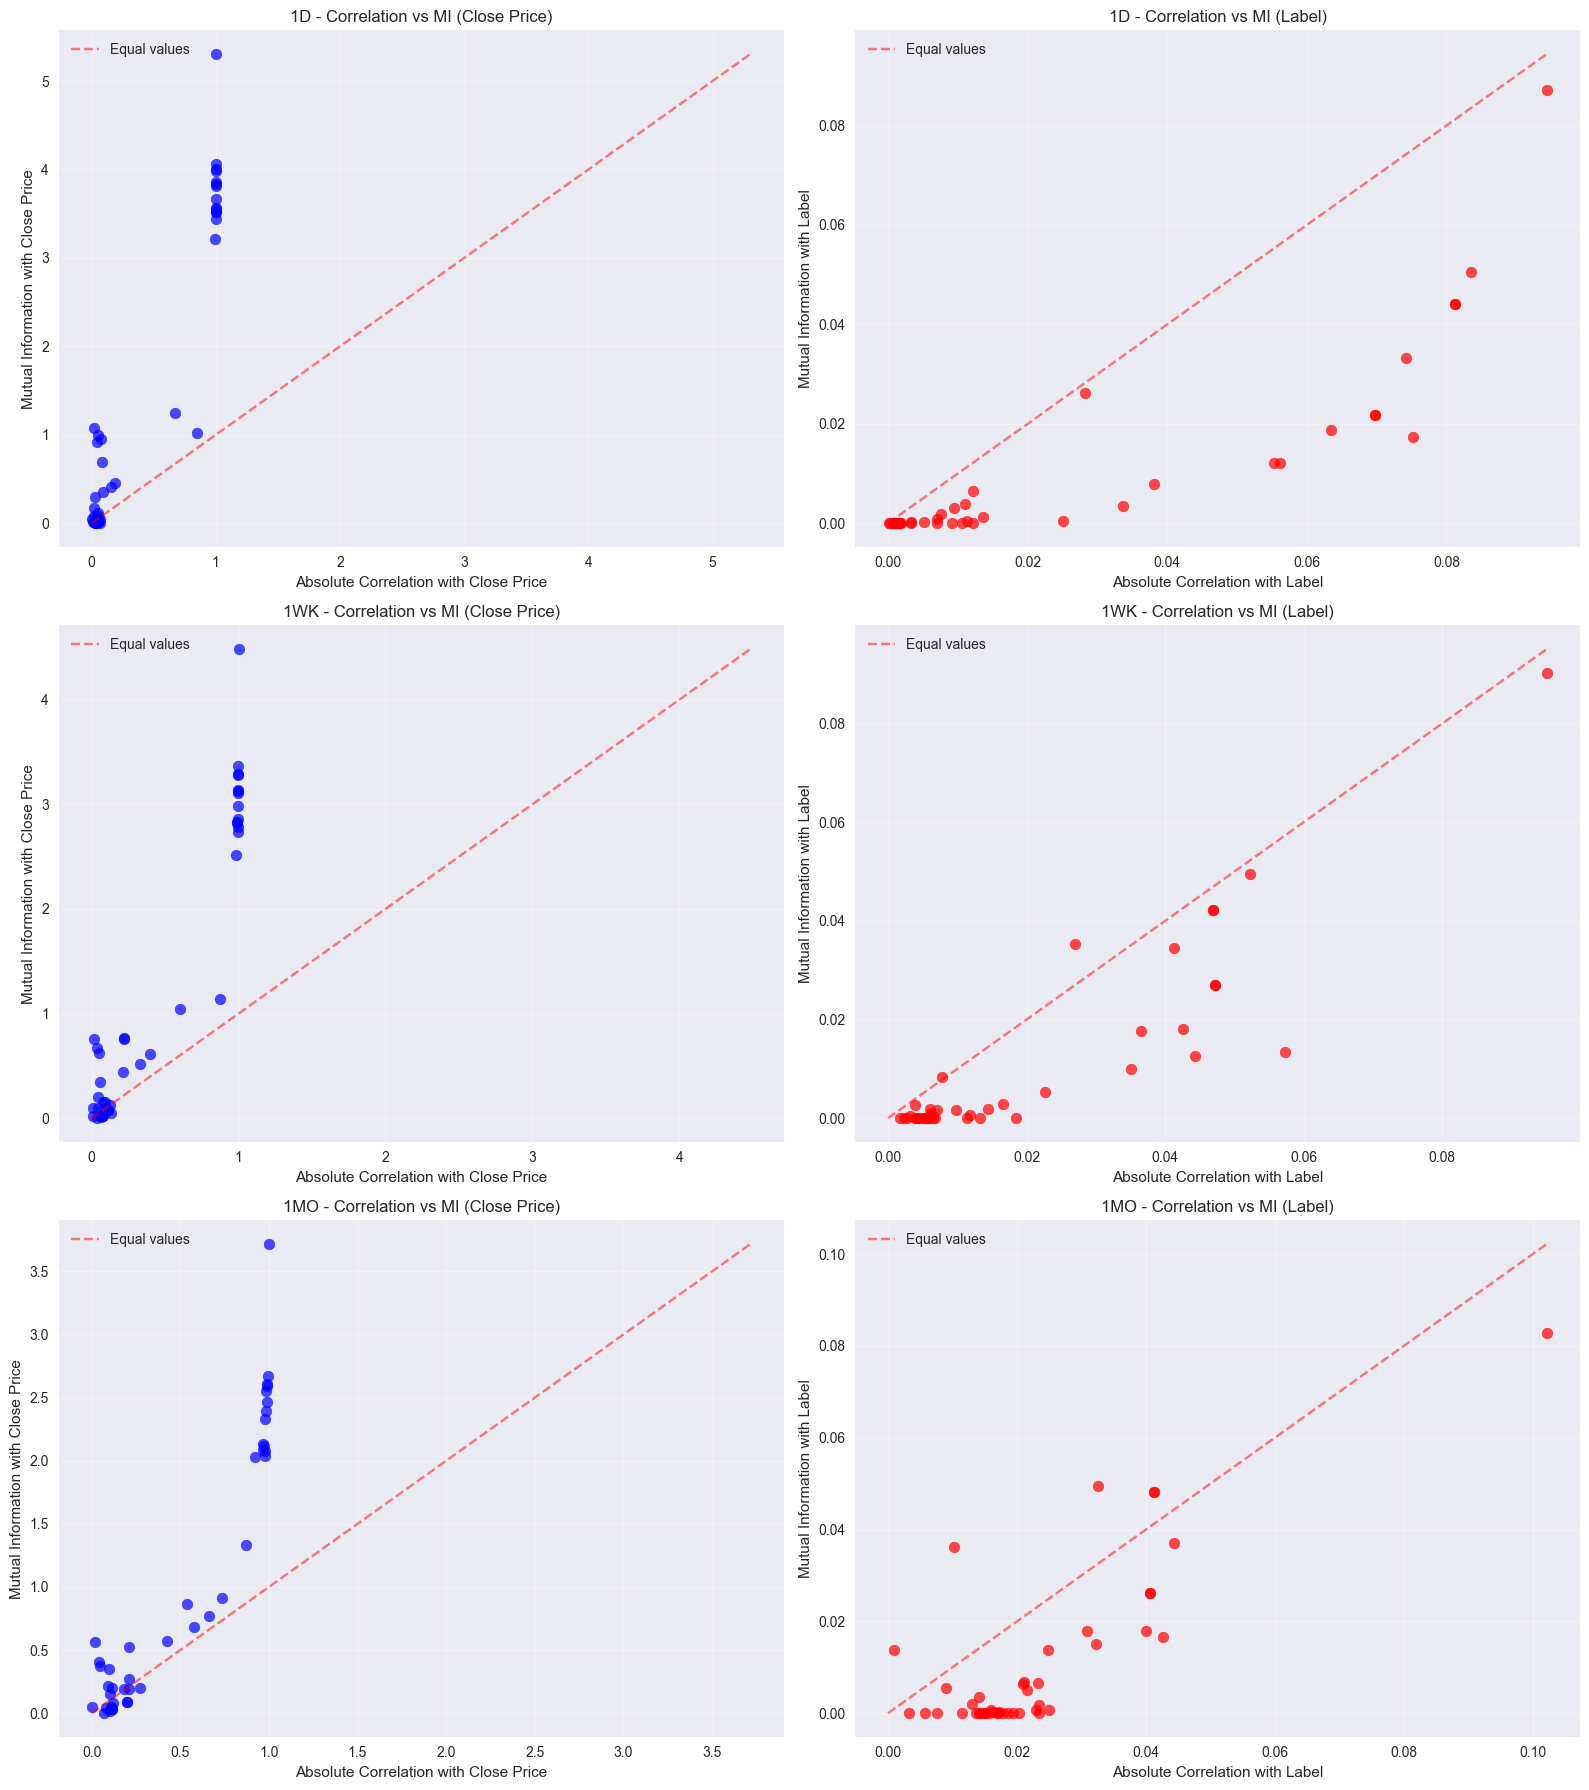

In [ ]:
# Visualize correlation vs mutual information
fig, axes = plt.subplots(len(comparison_mi_corr), 2, figsize=(16, 6*len(comparison_mi_corr)))
if len(comparison_mi_corr) == 1:
    axes = axes.reshape(1, -1)

for idx, (timeframe, comparison_df) in enumerate(comparison_mi_corr.items()):
    # Scatter plot: Correlation vs MI for Close price
    ax1 = axes[idx, 0]
    scatter1 = ax1.scatter(comparison_df['Correlation_Close'], comparison_df['MI_Close'], 
                          alpha=0.7, s=60, c='blue')
    ax1.set_xlabel('Absolute Correlation with Close Price')
    ax1.set_ylabel('Mutual Information with Close Price')
    ax1.set_title(f'{timeframe.upper()} - Correlation vs MI (Close Price)')
    ax1.grid(True, alpha=0.3)
    
    # Add diagonal reference line
    max_val = max(comparison_df['Correlation_Close'].max(), comparison_df['MI_Close'].max())
    ax1.plot([0, max_val], [0, max_val], 'r--', alpha=0.5, label='Equal values')
    ax1.legend()
    
    # Scatter plot: Correlation vs MI for Label
    ax2 = axes[idx, 1]
    scatter2 = ax2.scatter(comparison_df['Correlation_Label'], comparison_df['MI_Label'], 
                          alpha=0.7, s=60, c='red')
    ax2.set_xlabel('Absolute Correlation with Label')
    ax2.set_ylabel('Mutual Information with Label')
    ax2.set_title(f'{timeframe.upper()} - Correlation vs MI (Label)')
    ax2.grid(True, alpha=0.3)
    
    # Add diagonal reference line
    max_val = max(comparison_df['Correlation_Label'].max(), comparison_df['MI_Label'].max())
    ax2.plot([0, max_val], [0, max_val], 'r--', alpha=0.5, label='Equal values')
    ax2.legend()

plt.tight_layout()
plt.show()

## Principal Component Analysis (PCA)

PCA helps identify the most important patterns in the technical indicators by finding linear combinations that capture the maximum variance in the data. This analysis reveals which combinations of indicators explain the most variation in the dataset.

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Function to perform PCA analysis
def perform_pca_analysis(df, timeframe_name, n_components=None):
    """Perform PCA analysis on technical indicators."""
    
    # Get available indicators
    available_indicators = [ind for ind in technical_indicators if ind in df.columns]
    
    if len(available_indicators) < 5:
        print(f"Insufficient indicators for PCA in {timeframe_name}")
        return None
    
    # Prepare data - remove NaN values
    clean_df = df[available_indicators].dropna()
    
    if len(clean_df) < 50:
        print(f"Insufficient data for PCA in {timeframe_name}")
        return None
    
    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(clean_df)
    
    # Perform PCA
    if n_components is None:
        n_components = min(len(available_indicators), 20)  # Limit to 20 components for analysis
    
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)
    
    # Create results dictionary
    results = {
        'pca_model': pca,
        'scaler': scaler,
        'transformed_data': X_pca,
        'feature_names': available_indicators,
        'explained_variance_ratio': pca.explained_variance_ratio_,
        'cumulative_variance_ratio': np.cumsum(pca.explained_variance_ratio_),
        'components': pca.components_,
        'n_samples': len(clean_df),
        'original_data': clean_df
    }
    
    return results

# Perform PCA for all timeframes
pca_results = {}
for timeframe, df in data_dict.items():
    if df is not None:
        print(f"Performing PCA analysis for {timeframe}...")
        pca_result = perform_pca_analysis(df, timeframe)
        if pca_result is not None:
            pca_results[timeframe] = pca_result
            print(f"Completed {timeframe} - {pca_result['n_samples']} samples, {len(pca_result['feature_names'])} features")

print("\nPCA analysis completed for all timeframes.")

Performing PCA analysis for 1d...
Completed 1d - 82908 samples, 44 features
Performing PCA analysis for 1wk...
Completed 1wk - 17639 samples, 44 features
Performing PCA analysis for 1mo...
Completed 1mo - 3813 samples, 44 features

PCA analysis completed for all timeframes.


In [ ]:
# Display PCA results
for timeframe, results in pca_results.items():
    print(f"\n{'='*70}")
    print(f"PCA ANALYSIS - {timeframe.upper()}")
    print(f"{'='*70}")
    
    n_components = len(results['explained_variance_ratio'])
    print(f"Number of components: {n_components}")
    print(f"Number of features: {len(results['feature_names'])}")
    print(f"Number of samples: {results['n_samples']}")
    
    print(f"\nExplained Variance Ratio by Component:")
    for i, (var_ratio, cum_ratio) in enumerate(zip(results['explained_variance_ratio'], 
                                                   results['cumulative_variance_ratio'])):
        print(f"  PC{i+1}: {var_ratio:.4f} ({var_ratio*100:.2f}%) - Cumulative: {cum_ratio:.4f} ({cum_ratio*100:.2f}%)")
    
    # Find number of components for different variance thresholds
    variance_thresholds = [0.80, 0.90, 0.95, 0.99]
    print(f"\nComponents needed for variance explained:")
    for threshold in variance_thresholds:
        n_comp_needed = np.argmax(results['cumulative_variance_ratio'] >= threshold) + 1
        if results['cumulative_variance_ratio'][n_comp_needed-1] >= threshold:
            print(f"  {threshold*100:.0f}% variance: {n_comp_needed} components")
        else:
            print(f"  {threshold*100:.0f}% variance: More than {n_components} components needed")
    
    # Top contributing features for first few components
    print(f"\nTop contributing features for first 5 components:")
    for i in range(min(5, n_components)):
        component = results['components'][i]
        # Get absolute values and sort
        abs_loadings = np.abs(component)
        top_indices = np.argsort(abs_loadings)[::-1][:5]
        
        print(f"\n  PC{i+1} (explains {results['explained_variance_ratio'][i]*100:.2f}% variance):")
        for idx in top_indices:
            feature_name = results['feature_names'][idx]
            loading = component[idx]
            print(f"    {feature_name}: {loading:.4f}")


PCA ANALYSIS - 1D
Number of components: 20
Number of features: 44
Number of samples: 82908

Explained Variance Ratio by Component:
  PC1: 0.3699 (36.99%) - Cumulative: 0.3699 (36.99%)
  PC2: 0.2216 (22.16%) - Cumulative: 0.5915 (59.15%)
  PC3: 0.0848 (8.48%) - Cumulative: 0.6763 (67.63%)
  PC4: 0.0693 (6.93%) - Cumulative: 0.7456 (74.56%)
  PC5: 0.0353 (3.53%) - Cumulative: 0.7810 (78.10%)
  PC6: 0.0282 (2.82%) - Cumulative: 0.8092 (80.92%)
  PC7: 0.0226 (2.26%) - Cumulative: 0.8318 (83.18%)
  PC8: 0.0208 (2.08%) - Cumulative: 0.8526 (85.26%)
  PC9: 0.0189 (1.89%) - Cumulative: 0.8715 (87.15%)
  PC10: 0.0179 (1.79%) - Cumulative: 0.8894 (88.94%)
  PC11: 0.0167 (1.67%) - Cumulative: 0.9060 (90.60%)
  PC12: 0.0139 (1.39%) - Cumulative: 0.9199 (91.99%)
  PC13: 0.0136 (1.36%) - Cumulative: 0.9335 (93.35%)
  PC14: 0.0115 (1.15%) - Cumulative: 0.9450 (94.50%)
  PC15: 0.0112 (1.12%) - Cumulative: 0.9562 (95.62%)
  PC16: 0.0083 (0.83%) - Cumulative: 0.9646 (96.46%)
  PC17: 0.0064 (0.64%) - Cu

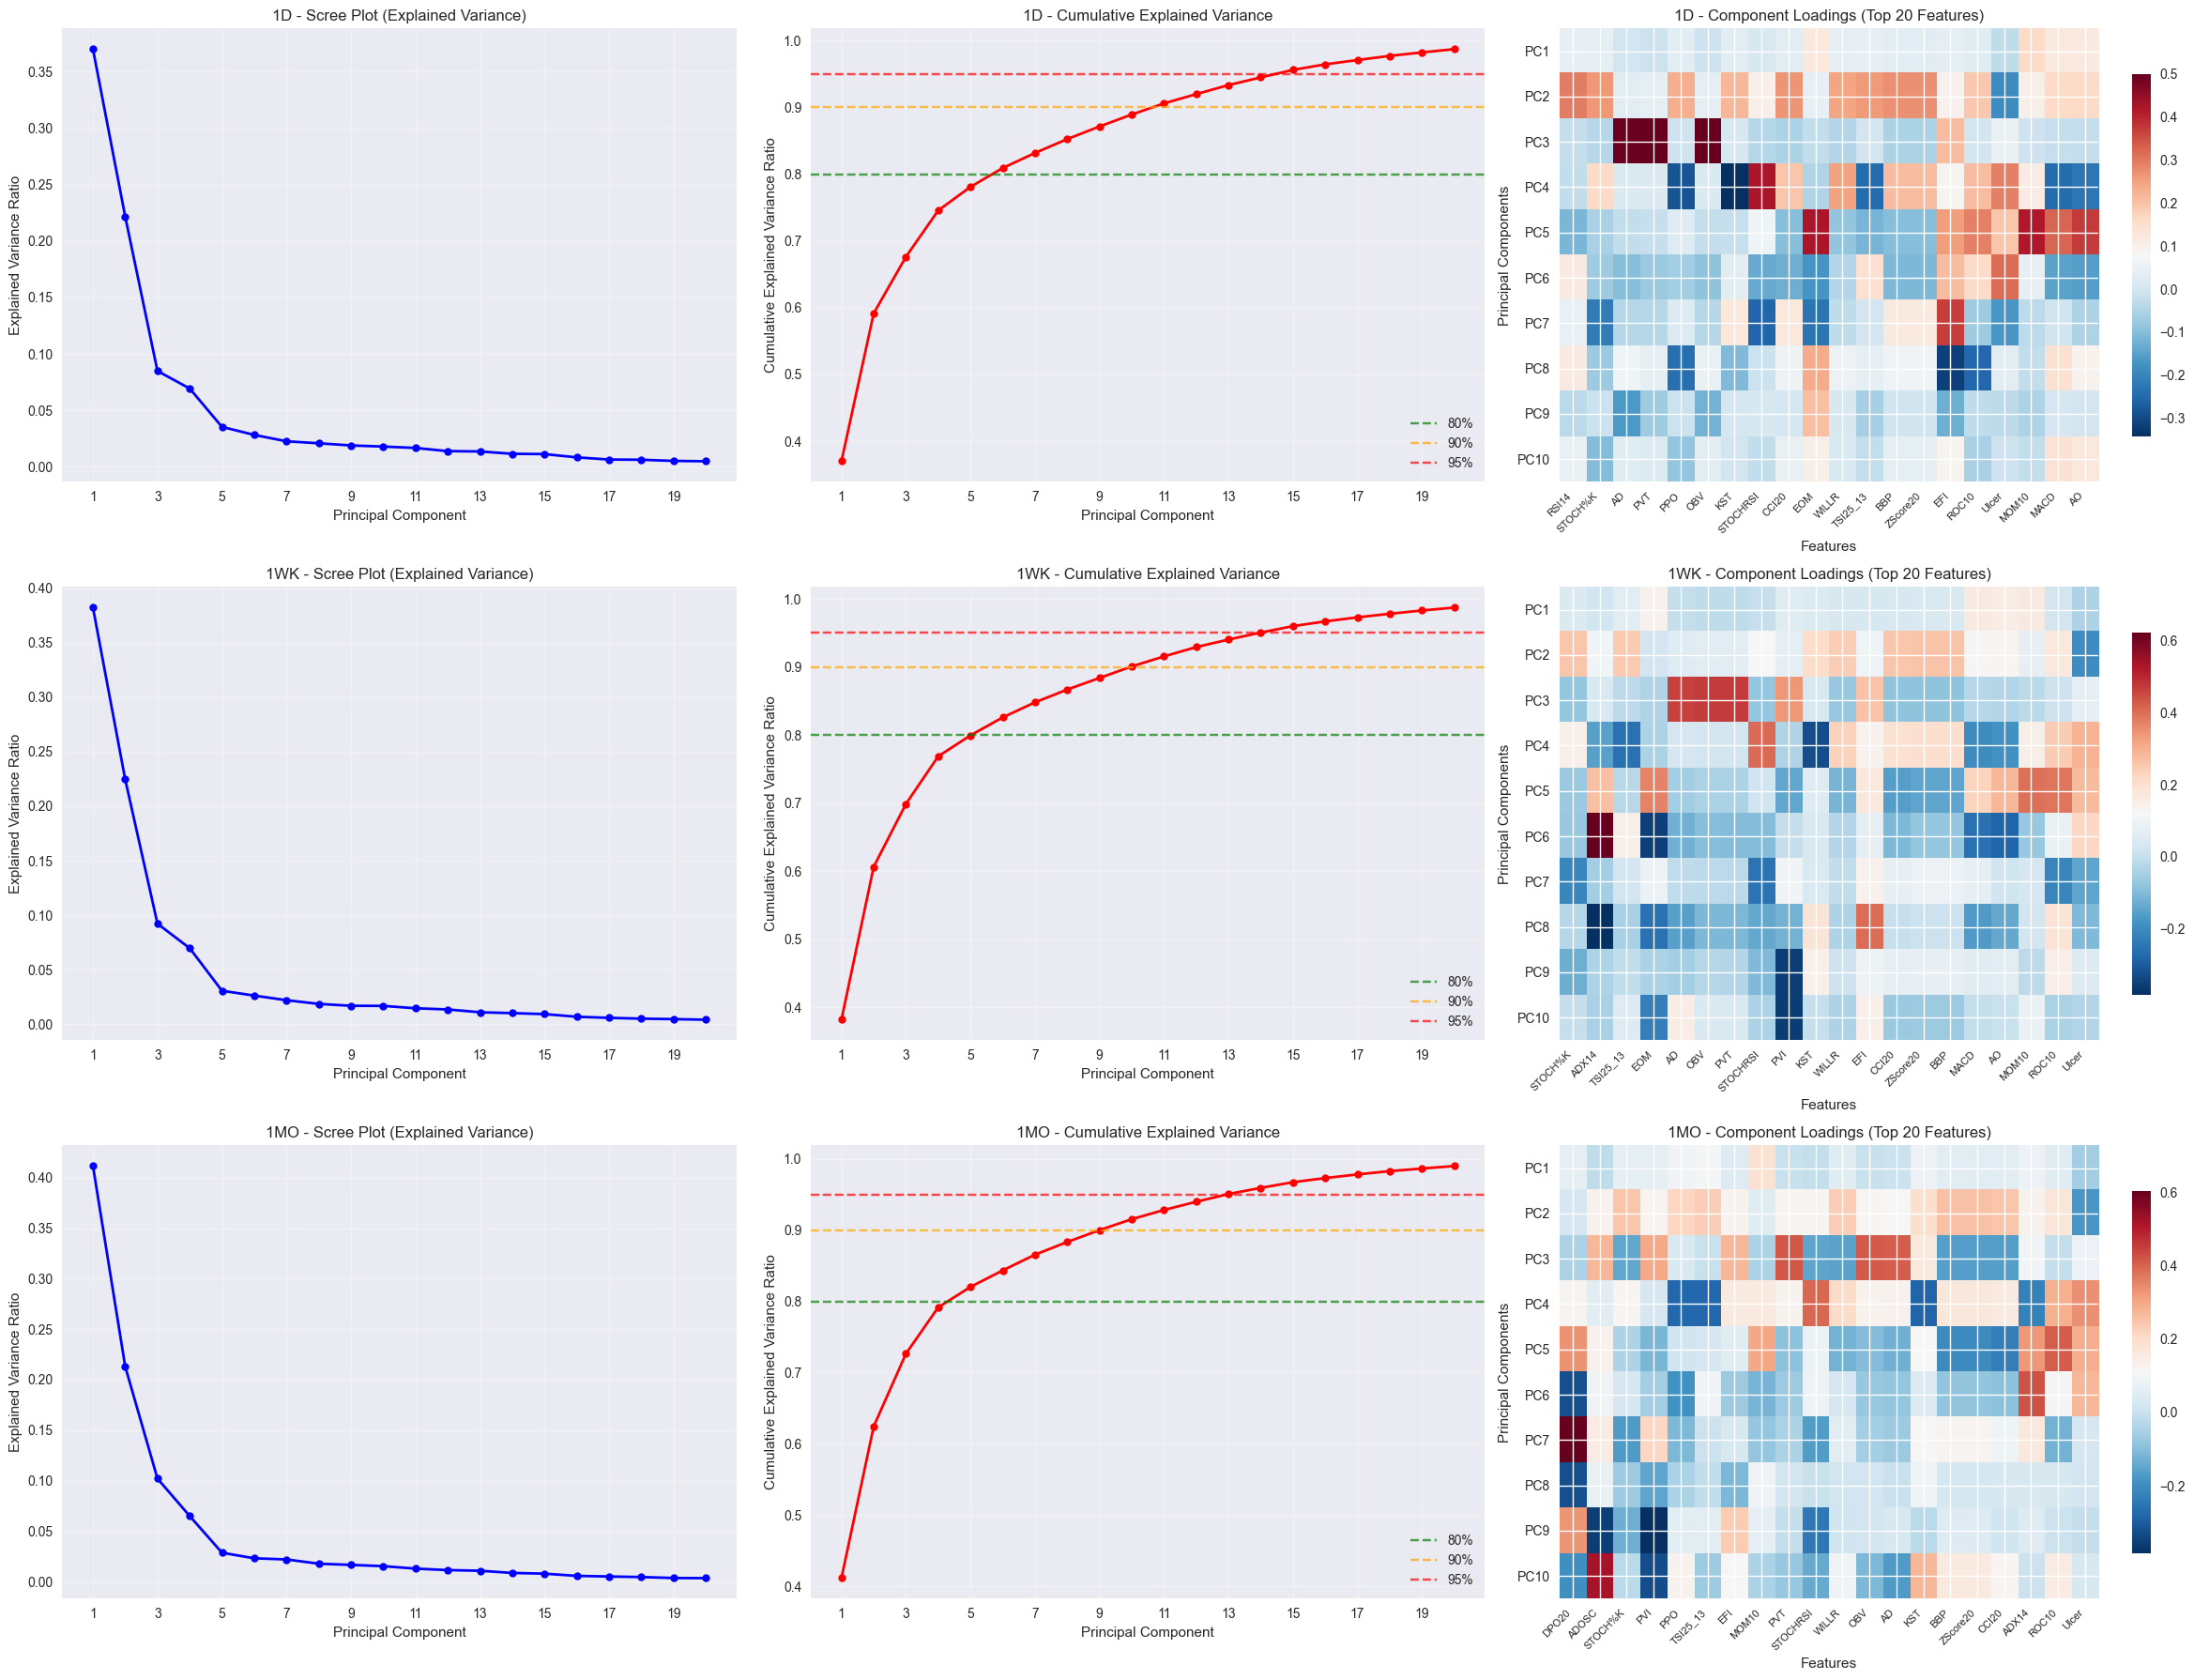

In [ ]:
# Visualize PCA results
fig, axes = plt.subplots(len(pca_results), 3, figsize=(24, 6*len(pca_results)))
if len(pca_results) == 1:
    axes = axes.reshape(1, -1)

for idx, (timeframe, results) in enumerate(pca_results.items()):
    n_components = len(results['explained_variance_ratio'])
    
    # Scree plot - Explained variance ratio
    ax1 = axes[idx, 0]
    components_range = range(1, n_components + 1)
    ax1.plot(components_range, results['explained_variance_ratio'], 'bo-', linewidth=2, markersize=6)
    ax1.set_title(f'{timeframe.upper()} - Scree Plot (Explained Variance)')
    ax1.set_xlabel('Principal Component')
    ax1.set_ylabel('Explained Variance Ratio')
    ax1.grid(True, alpha=0.3)
    ax1.set_xticks(components_range[::2])  # Show every other tick
    
    # Cumulative explained variance
    ax2 = axes[idx, 1]
    ax2.plot(components_range, results['cumulative_variance_ratio'], 'ro-', linewidth=2, markersize=6)
    ax2.axhline(y=0.8, color='green', linestyle='--', alpha=0.7, label='80%')
    ax2.axhline(y=0.9, color='orange', linestyle='--', alpha=0.7, label='90%')
    ax2.axhline(y=0.95, color='red', linestyle='--', alpha=0.7, label='95%')
    ax2.set_title(f'{timeframe.upper()} - Cumulative Explained Variance')
    ax2.set_xlabel('Principal Component')
    ax2.set_ylabel('Cumulative Explained Variance Ratio')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_xticks(components_range[::2])
    
    # Component loadings heatmap (first 10 components, top 20 features)
    ax3 = axes[idx, 2]
    n_comp_show = min(10, n_components)
    n_feat_show = min(20, len(results['feature_names']))
    
    # Get top features based on overall contribution across first few components
    overall_importance = np.sum(np.abs(results['components'][:5]), axis=0)
    top_feature_indices = np.argsort(overall_importance)[-n_feat_show:]
    
    loadings_subset = results['components'][:n_comp_show, top_feature_indices]
    feature_names_subset = [results['feature_names'][i] for i in top_feature_indices]
    
    im = ax3.imshow(loadings_subset, cmap='RdBu_r', aspect='auto')
    ax3.set_title(f'{timeframe.upper()} - Component Loadings (Top {n_feat_show} Features)')
    ax3.set_xlabel('Features')
    ax3.set_ylabel('Principal Components')
    
    # Set ticks and labels
    ax3.set_xticks(range(len(feature_names_subset)))
    ax3.set_xticklabels(feature_names_subset, rotation=45, ha='right', fontsize=8)
    ax3.set_yticks(range(n_comp_show))
    ax3.set_yticklabels([f'PC{i+1}' for i in range(n_comp_show)])
    
    # Add colorbar
    plt.colorbar(im, ax=ax3, shrink=0.8)

plt.tight_layout()
plt.show()

In [ ]:
# Analyze correlation between principal components and target variables
pca_target_correlations = {}

for timeframe, results in pca_results.items():
    if timeframe in data_dict:
        df = data_dict[timeframe]
        
        # Get clean data for the same samples used in PCA
        available_indicators = results['feature_names']
        clean_df = df[available_indicators + ['Close', 'Label']].dropna()
        
        # Ensure we're using the same samples
        if len(clean_df) >= results['n_samples']:
            clean_df = clean_df.iloc[:results['n_samples']]
            
            # Calculate correlations between PCs and targets
            pc_data = pd.DataFrame(results['transformed_data'], 
                                 columns=[f'PC{i+1}' for i in range(results['transformed_data'].shape[1])])
            
            # Add target variables
            pc_data['Close'] = clean_df['Close'].values
            pc_data['Label'] = clean_df['Label'].values
            
            # Calculate correlations
            pc_close_corr = pc_data.corr()['Close'].drop(['Close', 'Label'])
            pc_label_corr = pc_data.corr()['Label'].drop(['Close', 'Label'])
            
            pca_target_correlations[timeframe] = {
                'close_correlations': pc_close_corr,
                'label_correlations': pc_label_corr,
                'pc_data': pc_data
            }
            
            print(f"\n{'='*70}")
            print(f"PCA-TARGET CORRELATION ANALYSIS - {timeframe.upper()}")
            print(f"{'='*70}")
            
            print(f"\nCorrelations between Principal Components and Close Price:")
            for pc, corr in pc_close_corr.items():
                variance_explained = results['explained_variance_ratio'][int(pc[2:])-1]
                print(f"  {pc}: {corr:.4f} (explains {variance_explained*100:.2f}% variance)")
            
            print(f"\nCorrelations between Principal Components and Label:")
            for pc, corr in pc_label_corr.items():
                variance_explained = results['explained_variance_ratio'][int(pc[2:])-1]
                print(f"  {pc}: {corr:.4f} (explains {variance_explained*100:.2f}% variance)")
            
            # Find most predictive components
            top_close_pcs = pc_close_corr.abs().nlargest(5)
            top_label_pcs = pc_label_corr.abs().nlargest(5)
            
            print(f"\nMost predictive components for Close Price:")
            for pc, abs_corr in top_close_pcs.items():
                actual_corr = pc_close_corr[pc]
                variance_explained = results['explained_variance_ratio'][int(pc[2:])-1]
                print(f"  {pc}: {actual_corr:.4f} (explains {variance_explained*100:.2f}% variance)")
            
            print(f"\nMost predictive components for Label:")
            for pc, abs_corr in top_label_pcs.items():
                actual_corr = pc_label_corr[pc]
                variance_explained = results['explained_variance_ratio'][int(pc[2:])-1]
                print(f"  {pc}: {actual_corr:.4f} (explains {variance_explained*100:.2f}% variance)")


PCA-TARGET CORRELATION ANALYSIS - 1D

Correlations between Principal Components and Close Price:
  PC1: 0.9867 (explains 36.99% variance)
  PC2: -0.1471 (explains 22.16% variance)
  PC3: -0.0020 (explains 8.48% variance)
  PC4: 0.0104 (explains 6.93% variance)
  PC5: -0.0545 (explains 3.53% variance)
  PC6: 0.0039 (explains 2.82% variance)
  PC7: 0.0030 (explains 2.26% variance)
  PC8: 0.0004 (explains 2.08% variance)
  PC9: 0.0195 (explains 1.89% variance)
  PC10: -0.0072 (explains 1.79% variance)
  PC11: -0.0152 (explains 1.67% variance)
  PC12: -0.0065 (explains 1.39% variance)
  PC13: -0.0020 (explains 1.36% variance)
  PC14: 0.0060 (explains 1.15% variance)
  PC15: 0.0038 (explains 1.12% variance)
  PC16: -0.0016 (explains 0.83% variance)
  PC17: -0.0071 (explains 0.64% variance)
  PC18: -0.0039 (explains 0.62% variance)
  PC19: -0.0194 (explains 0.52% variance)
  PC20: 0.0086 (explains 0.49% variance)

Correlations between Principal Components and Label:
  PC1: 0.0121 (explains 

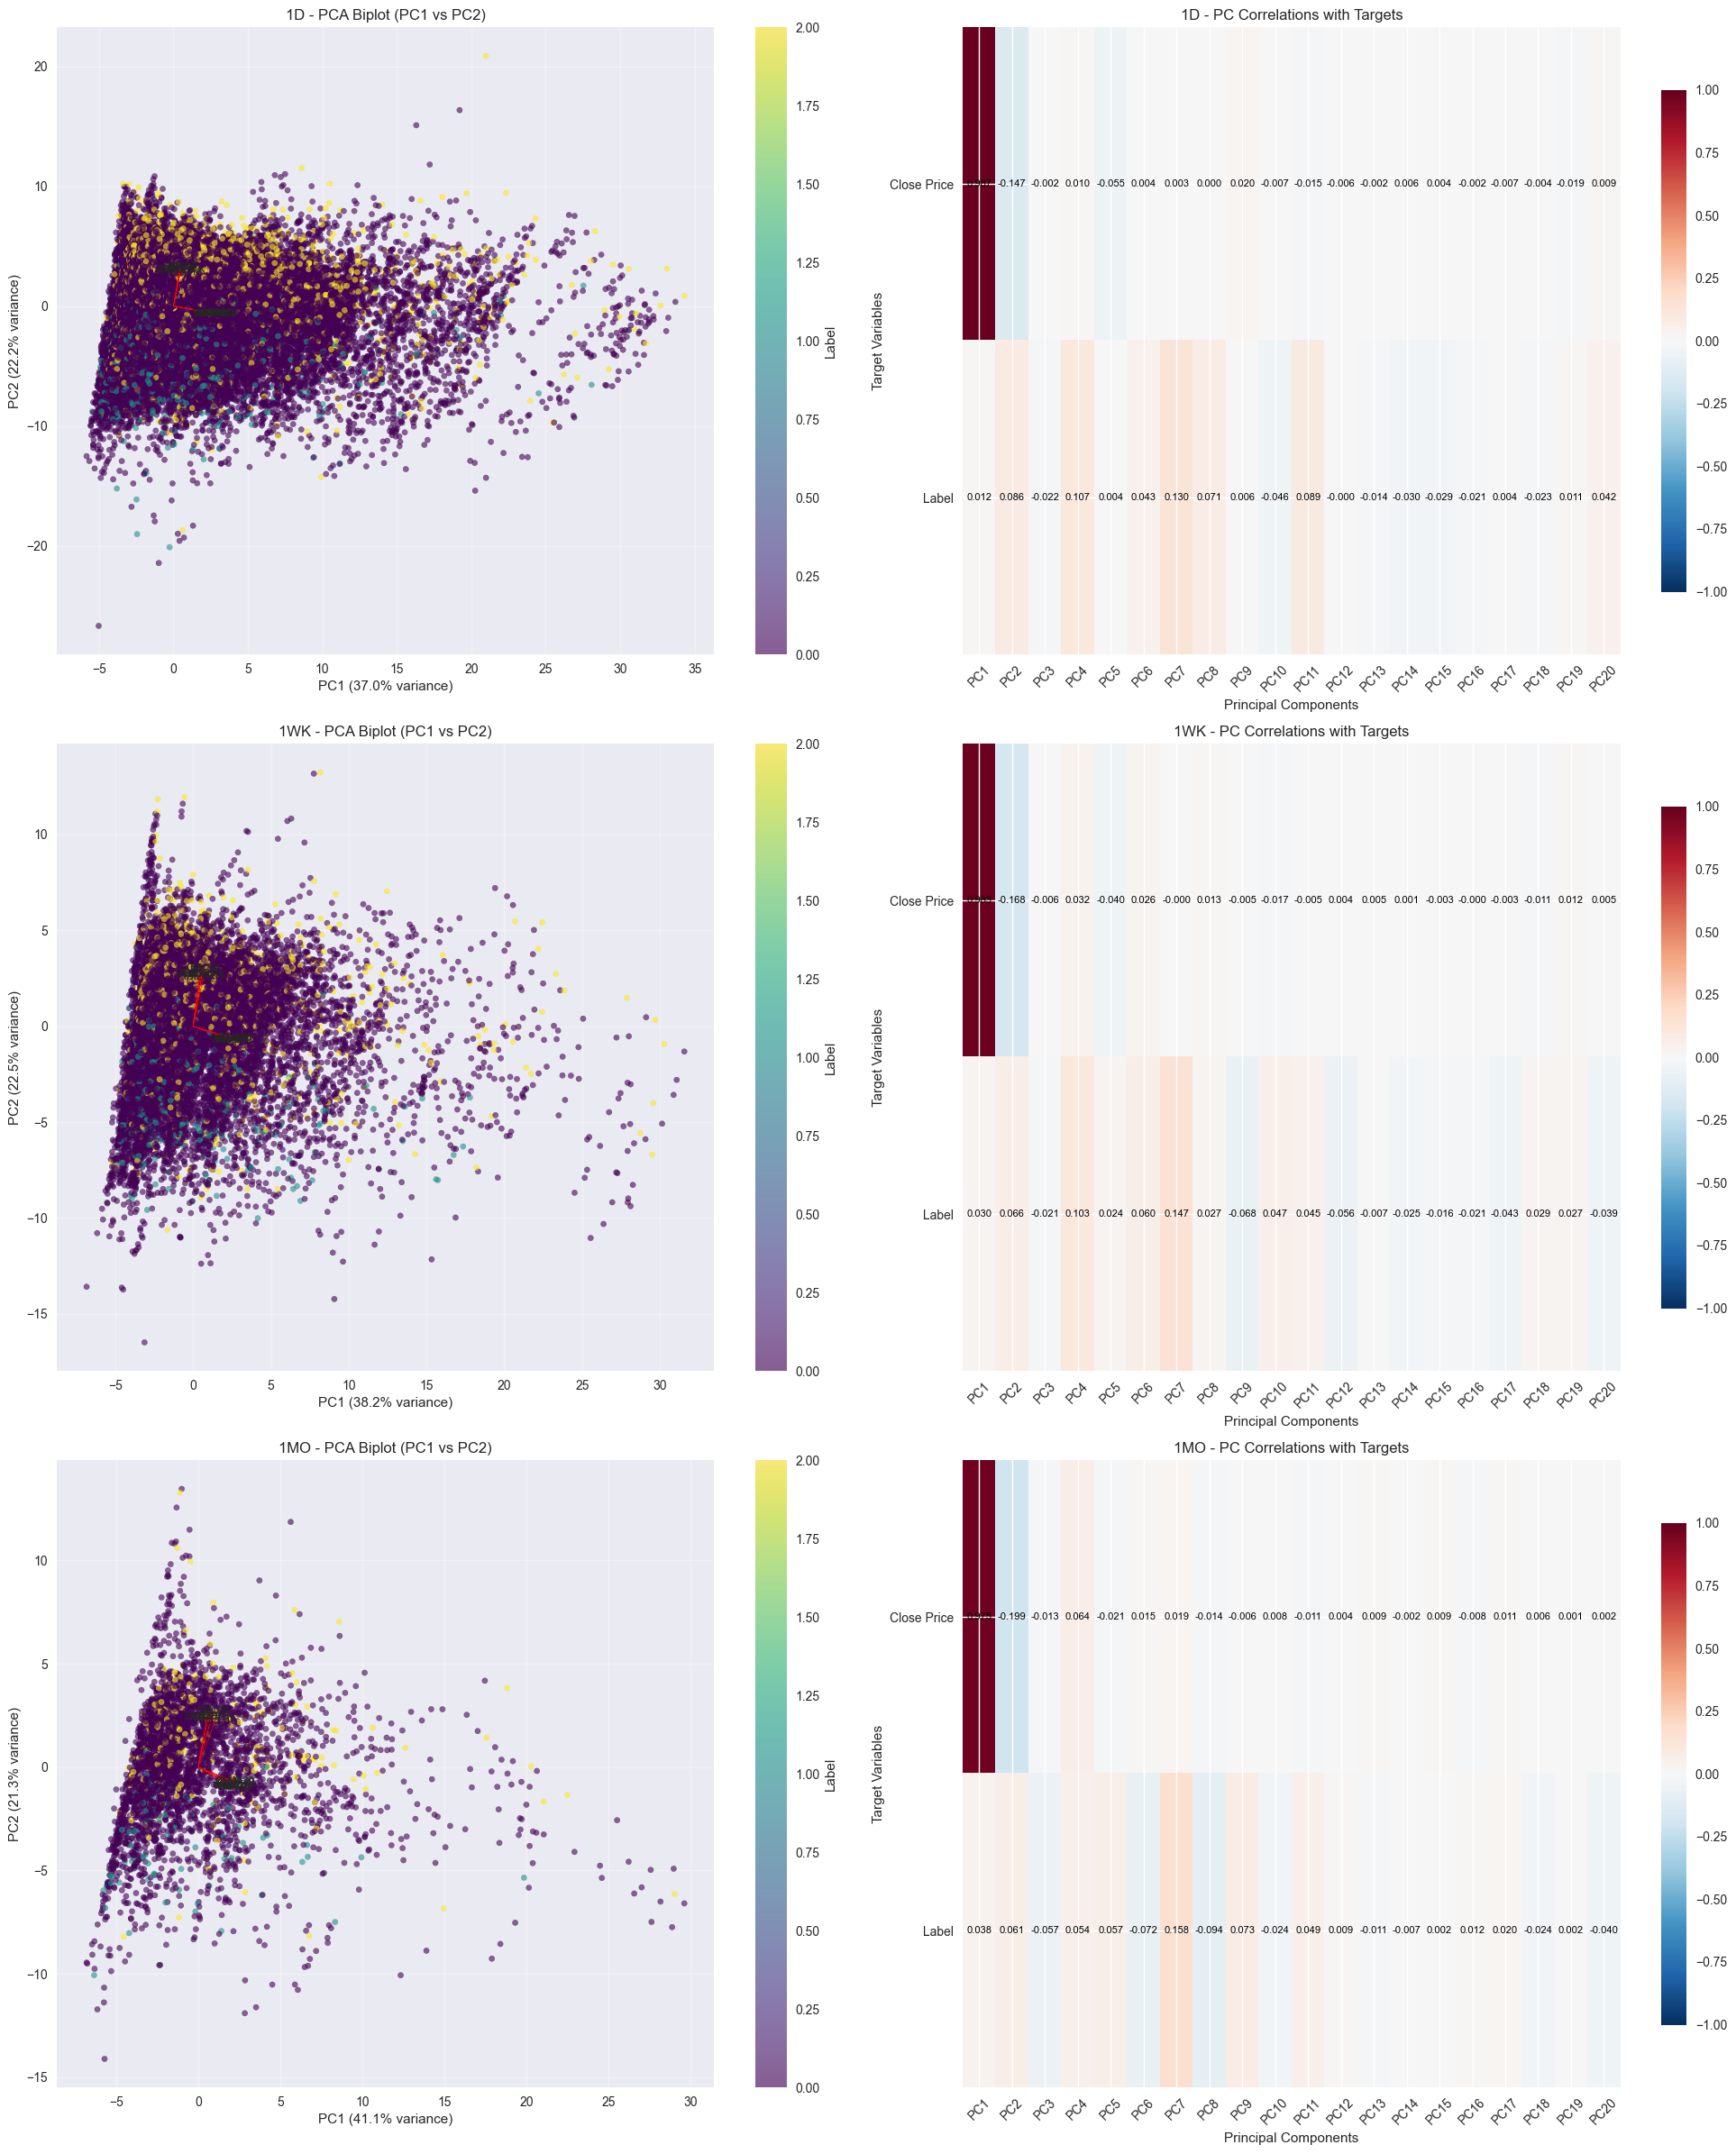

In [ ]:
# Create PCA biplots and component correlation visualizations
fig, axes = plt.subplots(len(pca_results), 2, figsize=(20, 8*len(pca_results)))
if len(pca_results) == 1:
    axes = axes.reshape(1, -1)

for idx, (timeframe, results) in enumerate(pca_results.items()):
    # Biplot: PC1 vs PC2 with feature loadings
    ax1 = axes[idx, 0]
    
    # Plot data points (sample scores)
    pc_scores = results['transformed_data']
    if timeframe in pca_target_correlations:
        # Color points by label if available
        labels = pca_target_correlations[timeframe]['pc_data']['Label']
        scatter = ax1.scatter(pc_scores[:, 0], pc_scores[:, 1], 
                            c=labels, cmap='viridis', alpha=0.6, s=20)
        plt.colorbar(scatter, ax=ax1, label='Label')
    else:
        ax1.scatter(pc_scores[:, 0], pc_scores[:, 1], alpha=0.6, s=20)
    
    # Plot feature loadings (arrows)
    loadings = results['components'][:2].T  # First 2 components
    feature_names = results['feature_names']
    
    # Scale loadings for visualization
    scale_factor = 0.3 * max(np.max(np.abs(pc_scores[:, 0])), np.max(np.abs(pc_scores[:, 1])))
    
    # Show only top contributing features to avoid clutter
    loading_magnitudes = np.sqrt(loadings[:, 0]**2 + loadings[:, 1]**2)
    top_features_idx = np.argsort(loading_magnitudes)[-15:]  # Top 15 features
    
    for i in top_features_idx:
        ax1.arrow(0, 0, loadings[i, 0]*scale_factor, loadings[i, 1]*scale_factor,
                 head_width=0.02*scale_factor, head_length=0.03*scale_factor, 
                 fc='red', ec='red', alpha=0.7)
        ax1.text(loadings[i, 0]*scale_factor*1.1, loadings[i, 1]*scale_factor*1.1,
                feature_names[i], fontsize=8, ha='center', va='center')
    
    var1 = results['explained_variance_ratio'][0]*100
    var2 = results['explained_variance_ratio'][1]*100
    ax1.set_xlabel(f'PC1 ({var1:.1f}% variance)')
    ax1.set_ylabel(f'PC2 ({var2:.1f}% variance)')
    ax1.set_title(f'{timeframe.upper()} - PCA Biplot (PC1 vs PC2)')
    ax1.grid(True, alpha=0.3)
    
    # PC-Target correlation heatmap
    ax2 = axes[idx, 1]
    if timeframe in pca_target_correlations:
        corr_data = np.array([
            pca_target_correlations[timeframe]['close_correlations'].values,
            pca_target_correlations[timeframe]['label_correlations'].values
        ])
        
        im = ax2.imshow(corr_data, cmap='RdBu_r', aspect='auto', vmin=-1, vmax=1)
        ax2.set_title(f'{timeframe.upper()} - PC Correlations with Targets')
        ax2.set_ylabel('Target Variables')
        ax2.set_xlabel('Principal Components')
        
        # Set ticks and labels
        pc_names = pca_target_correlations[timeframe]['close_correlations'].index
        ax2.set_xticks(range(len(pc_names)))
        ax2.set_xticklabels(pc_names, rotation=45)
        ax2.set_yticks([0, 1])
        ax2.set_yticklabels(['Close Price', 'Label'])
        
        # Add correlation values as text
        for i in range(2):
            for j in range(len(pc_names)):
                text = ax2.text(j, i, f'{corr_data[i, j]:.3f}',
                               ha="center", va="center", color="black", fontsize=8)
        
        plt.colorbar(im, ax=ax2, shrink=0.8)
    else:
        ax2.text(0.5, 0.5, 'No target correlation data available', 
                ha='center', va='center', transform=ax2.transAxes)
        ax2.set_title(f'{timeframe.upper()} - PC Correlations with Targets')

plt.tight_layout()
plt.show()

In [ ]:
# Analyze top correlated indicators for each timeframe
for timeframe, results in correlation_results.items():
    print(f"\n{'='*60}")
    print(f"TOP CORRELATED INDICATORS - {timeframe.upper()}")
    print(f"{'='*60}")
    
    # Top 5 indicators correlated with Close price
    top_close_corr = results['close_correlations'].abs().nlargest(5)
    print(f"\nTop 5 indicators correlated with Close Price:")
    for indicator, corr in top_close_corr.items():
        actual_corr = results['close_correlations'][indicator]
        print(f"  {indicator}: {actual_corr:.4f}")
    
    # Top 5 indicators correlated with Label
    top_label_corr = results['label_correlations'].abs().nlargest(5)
    print(f"\nTop 5 indicators correlated with Label:")
    for indicator, corr in top_label_corr.items():
        actual_corr = results['label_correlations'][indicator]
        print(f"  {indicator}: {actual_corr:.4f}")
    
    # Add mutual information comparison if available
    if timeframe in mi_results:
        print(f"\nTop 5 indicators by Mutual Information with Label:")
        top_mi_label = mi_results[timeframe]['label_mi'].nlargest(5)
        for indicator, mi_score in top_mi_label.items():
            print(f"  {indicator}: {mi_score:.4f}")
    
    # Add PCA insights if available
    if timeframe in pca_results:
        print(f"\nPCA Insights:")
        pca_result = pca_results[timeframe]
        var_80 = np.argmax(pca_result['cumulative_variance_ratio'] >= 0.8) + 1
        var_95 = np.argmax(pca_result['cumulative_variance_ratio'] >= 0.95) + 1
        print(f"  Components for 80% variance: {var_80}")
        print(f"  Components for 95% variance: {var_95}")
        
        # Most important features in first PC
        first_pc = pca_result['components'][0]
        top_pc1_indices = np.argsort(np.abs(first_pc))[-3:]
        print(f"  Top 3 features in PC1:")
        for idx in reversed(top_pc1_indices):
            feature_name = pca_result['feature_names'][idx]
            loading = first_pc[idx]
            print(f"    {feature_name}: {loading:.4f}")


TOP CORRELATED INDICATORS - 1D

Top 5 indicators correlated with Close Price:
  VWAP: 1.0000
  TEMA20: 0.9996
  ZLMA20: 0.9995
  DEMA20: 0.9994
  HMA20: 0.9994

Top 5 indicators correlated with Label:
  DPO20: 0.0944
  WILLR: 0.0834
  BBP: 0.0813
  ZScore20: 0.0813
  RVI: 0.0752

Top 5 indicators by Mutual Information with Label:
  DPO20: 0.0871
  WILLR: 0.0506
  ZScore20: 0.0442
  BBP: 0.0442
  CCI20: 0.0331

PCA Insights:
  Components for 80% variance: 6
  Components for 95% variance: 15
  Top 3 features in PC1:
    TEMA20: 0.2447
    HMA20: 0.2446
    VWAP: 0.2446

TOP CORRELATED INDICATORS - 1WK

Top 5 indicators correlated with Close Price:
  VWAP: 0.9998
  TEMA20: 0.9982
  ZLMA20: 0.9977
  DEMA20: 0.9974
  HMA20: 0.9971

Top 5 indicators correlated with Label:
  DPO20: 0.0951
  RVI: 0.0573
  WILLR: 0.0522
  RSI14: 0.0472
  CMO14: 0.0472

Top 5 indicators by Mutual Information with Label:
  DPO20: 0.0902
  WILLR: 0.0495
  BBP: 0.0422
  ZScore20: 0.0422
  EFI: 0.0353

PCA Insights

## Cross-Timeframe Comparison

In [ ]:
# Compare correlations across timeframes
def create_comparison_dataframe(correlation_results, target='close'):
    """Create a comparison dataframe for correlations across timeframes."""
    comparison_data = {}
    
    for timeframe, results in correlation_results.items():
        if target == 'close':
            comparison_data[timeframe] = results['close_correlations']
        else:
            comparison_data[timeframe] = results['label_correlations']
    
    return pd.DataFrame(comparison_data)

# Create comparison dataframes
close_comparison = create_comparison_dataframe(correlation_results, 'close')
label_comparison = create_comparison_dataframe(correlation_results, 'label')

print("Cross-Timeframe Comparison - Correlations with Close Price:")
print(close_comparison)

print("\nCross-Timeframe Comparison - Correlations with Label:")
print(label_comparison)

Cross-Timeframe Comparison - Correlations with Close Price:
                1d       1wk       1mo
SMA20     0.998250  0.992724  0.968622
EMA20     0.998743  0.994587  0.979133
WMA20     0.998966  0.995542  0.981491
HMA20     0.999396  0.997058  0.989629
TEMA20    0.999592  0.998171  0.993004
VWMA20    0.998548  0.993898  0.972588
KAMA10    0.998949  0.995166  0.984040
DEMA20    0.999399  0.997397  0.989457
ZLMA20    0.999506  0.997676  0.991430
TRIMA20   0.998092  0.991895  0.964352
RSI14     0.056642  0.113119  0.200434
STOCH%K   0.044528  0.076858  0.113079
STOCHRSI  0.013585  0.007858 -0.000792
CCI20     0.033045  0.071166  0.110162
CMO14     0.056642  0.113119  0.200434
ROC10     0.029962  0.062081  0.111238
PPO       0.043751  0.082333  0.184554
MACD      0.190193  0.397686  0.736712
AO        0.156298  0.326578  0.663928
KST       0.054335  0.088307  0.213325
WILLR     0.041402  0.072977  0.106199
MOM10     0.095531  0.215590  0.425844
DPO20     0.026834  0.053803  0.097607
TSI2

## Visualization: Cross-Timeframe Comparison

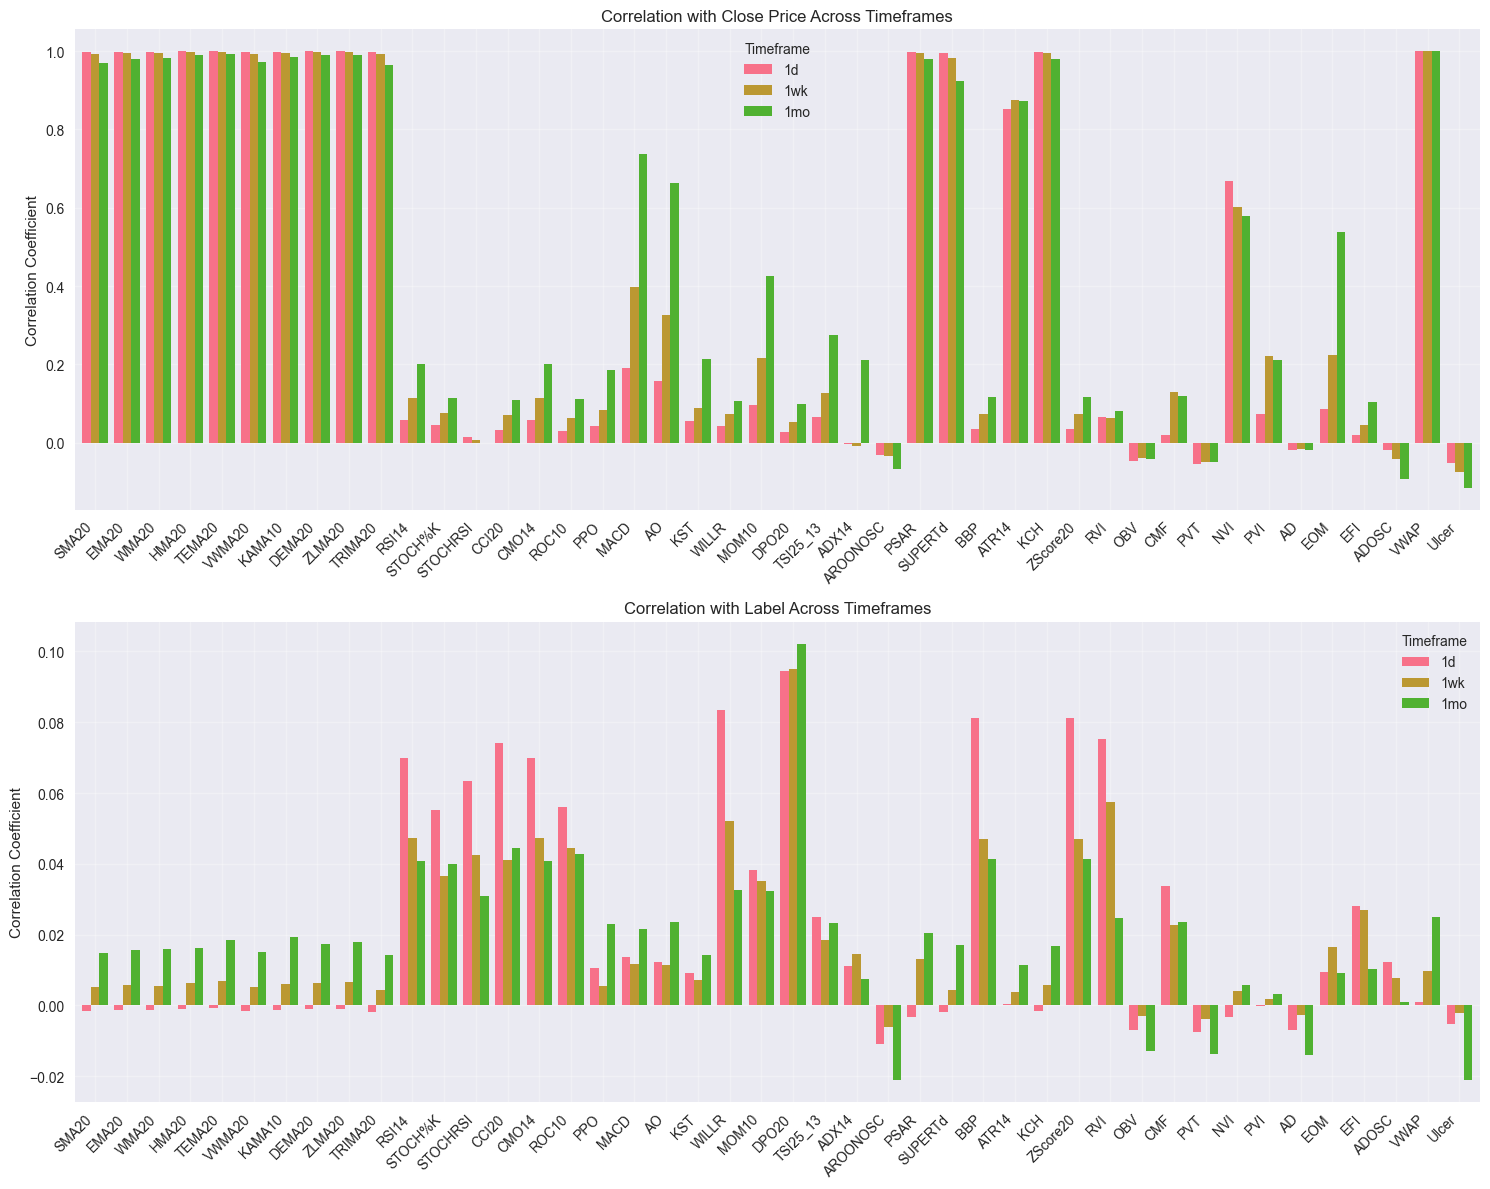

In [ ]:
# Create comparison plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# Plot Close price correlations comparison
close_comparison.plot(kind='bar', ax=ax1, width=0.8)
ax1.set_title('Correlation with Close Price Across Timeframes')
ax1.set_ylabel('Correlation Coefficient')
ax1.legend(title='Timeframe')
ax1.grid(True, alpha=0.3)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Plot Label correlations comparison
label_comparison.plot(kind='bar', ax=ax2, width=0.8)
ax2.set_title('Correlation with Label Across Timeframes')
ax2.set_ylabel('Correlation Coefficient')
ax2.legend(title='Timeframe')
ax2.grid(True, alpha=0.3)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

## Statistical Significance Analysis

In [ ]:
from scipy import stats

# Function to calculate correlation with p-values
def calculate_correlation_with_pvalue(df, indicator, target):
    """Calculate correlation and p-value between indicator and target."""
    if indicator not in df.columns or target not in df.columns:
        return None, None
    
    # Remove NaN values
    clean_data = df[[indicator, target]].dropna()
    
    if len(clean_data) < 3:
        return None, None
    
    correlation, p_value = stats.pearsonr(clean_data[indicator], clean_data[target])
    return correlation, p_value

# Calculate correlations with p-values for each timeframe
significance_results = {}

for timeframe, df in data_dict.items():
    if df is not None:
        print(f"\n{'='*60}")
        print(f"STATISTICAL SIGNIFICANCE - {timeframe.upper()}")
        print(f"{'='*60}")
        
        significance_data = {}
        
        # Use the updated technical indicators list
        available_indicators = [ind for ind in technical_indicators if ind in df.columns]
        
        for indicator in available_indicators:
            # Correlation with Close price
            close_corr, close_p = calculate_correlation_with_pvalue(df, indicator, 'Close')
            
            # Correlation with Label
            label_corr, label_p = calculate_correlation_with_pvalue(df, indicator, 'Label')
            
            if close_corr is not None and label_corr is not None:
                significance_data[indicator] = {
                    'close_correlation': close_corr,
                    'close_p_value': close_p,
                    'close_significant': close_p < 0.05,
                    'label_correlation': label_corr,
                    'label_p_value': label_p,
                    'label_significant': label_p < 0.05
                }
        
        # Create summary dataframe
        summary_df = pd.DataFrame(significance_data).T
        
        print("\nCorrelations with Close Price (significant at p < 0.05):")
        significant_close = summary_df[summary_df['close_significant']].sort_values('close_correlation', key=abs, ascending=False)
        print(significant_close[['close_correlation', 'close_p_value']])
        
        print("\nCorrelations with Label (significant at p < 0.05):")
        significant_label = summary_df[summary_df['label_significant']].sort_values('label_correlation', key=abs, ascending=False)
        print(significant_label[['label_correlation', 'label_p_value']])
        
        significance_results[timeframe] = summary_df


STATISTICAL SIGNIFICANCE - 1D

Correlations with Close Price (significant at p < 0.05):
         close_correlation close_p_value
VWAP              0.999973           0.0
TEMA20            0.999592           0.0
ZLMA20            0.999506           0.0
DEMA20            0.999399           0.0
HMA20             0.999396           0.0
WMA20             0.998966           0.0
PSAR               0.99896           0.0
KAMA10            0.998949           0.0
EMA20             0.998743           0.0
KCH               0.998657           0.0
VWMA20            0.998548           0.0
SMA20              0.99825           0.0
TRIMA20           0.998092           0.0
SUPERTd            0.99646           0.0
ATR14             0.851282           0.0
NVI               0.667872           0.0
MACD              0.190193           0.0
AO                0.156298           0.0
MOM10             0.095531           0.0
EOM               0.085448           0.0
PVI               0.072159           0.0
RVI      

## Summary and Insights

In [ ]:
# Generate summary insights
print("="*80)
print("EDA SUMMARY AND INSIGHTS")
print("="*80)

for timeframe, df in data_dict.items():
    if df is not None:
        print(f"\n{timeframe.upper()} TIMEFRAME:")
        print(f"- Total samples: {len(df):,}")
        print(f"- Unique symbols: {df['Symbol'].nunique()}")
        print(f"- Date range: {df['Date'].min()} to {df['Date'].max()}")
        print(f"- Label distribution: {dict(df['Label'].value_counts().sort_index())}")
        
        if timeframe in correlation_results:
            # Most correlated with Close price
            top_close = correlation_results[timeframe]['close_correlations'].abs().idxmax()
            top_close_corr = correlation_results[timeframe]['close_correlations'][top_close]
            print(f"- Most correlated with Close: {top_close} ({top_close_corr:.4f})")
            
            # Most correlated with Label
            top_label = correlation_results[timeframe]['label_correlations'].abs().idxmax()
            top_label_corr = correlation_results[timeframe]['label_correlations'][top_label]
            print(f"- Most correlated with Label: {top_label} ({top_label_corr:.4f})")
            
            # Number of significant correlations
            if timeframe in significance_results:
                sig_close_count = significance_results[timeframe]['close_significant'].sum()
                sig_label_count = significance_results[timeframe]['label_significant'].sum()
                total_indicators = len([ind for ind in technical_indicators if ind in df.columns])
                print(f"- Significant correlations with Close: {sig_close_count}/{total_indicators}")
                print(f"- Significant correlations with Label: {sig_label_count}/{total_indicators}")
        
        # Time lag correlation insights
        if timeframe in lag_correlation_results:
            lag_df = pd.DataFrame(lag_correlation_results[timeframe]).T.fillna(0)
            
            # Best lagged correlation
            best_lag_indicator = lag_df.abs().max(axis=1).idxmax()
            best_lag_corr = lag_df.abs().max(axis=1).max()
            best_lag_period = int(lag_df.abs().idxmax(axis=1)[best_lag_indicator].split('_')[1])
            actual_best_corr = lag_df.loc[best_lag_indicator, f'lag_{best_lag_period}']
            print(f"- Best lagged correlation: {best_lag_indicator} at lag {best_lag_period} ({actual_best_corr:.4f})")
            
            # Indicators that improve with lagging
            if timeframe in comparison_results:
                improved_indicators = comparison_results[timeframe][comparison_results[timeframe]['Improvement'] > 0.05]
                print(f"- Indicators improved by lagging (>0.05): {len(improved_indicators)}")

print("\n" + "="*80)
print("KEY FINDINGS:")
print("="*80)

# Overall insights
print("1. Data Coverage:")
for tf in timeframes:
    if tf in data_dict and data_dict[tf] is not None:
        print(f"   - {tf}: {len(data_dict[tf]):,} samples from {data_dict[tf]['Symbol'].nunique()} symbols")

print("\n2. Technical Indicators:")
print(f"   - Analyzed {len(technical_indicators)} technical indicators")
print("   - Categories included:")
print("     * Moving Averages: SMA20, EMA20, WMA20, HMA20, TEMA20, VWMA20, KAMA10, DEMA20, ZLMA20, TRIMA20")
print("     * Momentum: RSI14, STOCH%K, STOCHRSI, CMO14, ROC10, MOM10, TSI25_13")
print("     * Volatility: ATR14, BBP, Ulcer")
print("     * Volume: OBV, CMF, PVT, NVI, PVI, AD, EOM, EFI, ADOSC, VWAP")
print("     * Trend: CCI20, PPO, MACD, AO, KST, WILLR, DPO20, ADX14, AROONOSC, PSAR, SUPERTd")
print("     * Statistical: KCH, ZScore20, RVI")

print("\n3. Correlation Patterns:")
if correlation_results:
    # Find most consistently correlated indicators across timeframes
    all_close_corrs = pd.concat([results['close_correlations'] for results in correlation_results.values()], axis=1)
    all_close_corrs.columns = list(correlation_results.keys())
    
    # Average absolute correlation across timeframes
    avg_abs_corr = all_close_corrs.abs().mean(axis=1).sort_values(ascending=False)
    print(f"   - Most consistently correlated with Close: {avg_abs_corr.index[0]} ({avg_abs_corr.iloc[0]:.4f})")
    
    all_label_corrs = pd.concat([results['label_correlations'] for results in correlation_results.values()], axis=1)
    all_label_corrs.columns = list(correlation_results.keys())
    
    avg_abs_label_corr = all_label_corrs.abs().mean(axis=1).sort_values(ascending=False)
    print(f"   - Most consistently correlated with Label: {avg_abs_label_corr.index[0]} ({avg_abs_label_corr.iloc[0]:.4f})")

print("\n4. Time Lag Analysis:")
if lag_correlation_results:
    print("   - Analyzed correlations with up to 10 periods of lag")
    
    # Find indicators that consistently benefit from lagging across timeframes
    improvements_across_timeframes = []
    for tf, comp_df in comparison_results.items():
        significant_improvements = comp_df[comp_df['Improvement'] > 0.05]
        improvements_across_timeframes.extend(significant_improvements.index.tolist())
    
    from collections import Counter
    improvement_counts = Counter(improvements_across_timeframes)
    
    if improvement_counts:
        most_improved = improvement_counts.most_common(3)
        print(f"   - Indicators most improved by lagging: {[ind for ind, count in most_improved]}")
    
    # Overall lag patterns
    all_best_lags = []
    for tf, comp_df in comparison_results.items():
        all_best_lags.extend(comp_df['Best_Lag_Period'].tolist())
    
    if all_best_lags:
        from collections import Counter
        lag_counter = Counter(all_best_lags)
        most_common_lag = lag_counter.most_common(1)[0][0]
        print(f"   - Most common optimal lag period: {most_common_lag} periods")

print("\n4. Mutual Information Analysis:")
if mi_results:
    print("   - Captured non-linear relationships beyond correlation")
    # Find indicators with highest MI/correlation ratios across timeframes
    high_ratio_indicators = []
    for tf, comp_df in comparison_mi_corr.items():
        # Focus on label predictions
        label_ratios = comp_df['MI_Label'] / (comp_df['Correlation_Label'] + 1e-10)
        top_ratio_indicators = label_ratios.nlargest(3).index.tolist()
        high_ratio_indicators.extend(top_ratio_indicators)
    
    from collections import Counter
    if high_ratio_indicators:
        most_nonlinear = Counter(high_ratio_indicators).most_common(3)
        print(f"   - Indicators with strongest non-linear relationships: {[ind for ind, count in most_nonlinear]}")
    
    # Average MI scores across timeframes
    all_mi_scores = []
    for tf_results in mi_results.values():
        all_mi_scores.append(tf_results['label_mi'])
    
    if all_mi_scores:
        avg_mi = pd.concat(all_mi_scores, axis=1).mean(axis=1).sort_values(ascending=False)
        print(f"   - Highest average MI with Label: {avg_mi.index[0]} ({avg_mi.iloc[0]:.4f})")

print("\n5. PCA Analysis:")
if pca_results:
    print("   - Dimensionality reduction reveals underlying patterns in technical indicators")
    
    # Average components needed across timeframes
    components_80 = []
    components_95 = []
    for results in pca_results.values():
        comp_80 = np.argmax(results['cumulative_variance_ratio'] >= 0.8) + 1
        comp_95 = np.argmax(results['cumulative_variance_ratio'] >= 0.95) + 1
        components_80.append(comp_80)
        components_95.append(comp_95)
    
    if components_80 and components_95:
        avg_80 = np.mean(components_80)
        avg_95 = np.mean(components_95)
        print(f"   - Average components for 80% variance: {avg_80:.1f}")
        print(f"   - Average components for 95% variance: {avg_95:.1f}")
    
    # Most consistently important features across first PCs
    first_pc_features = []
    for results in pca_results.values():
        first_pc = results['components'][0]
        top_indices = np.argsort(np.abs(first_pc))[-3:]
        top_features = [results['feature_names'][idx] for idx in top_indices]
        first_pc_features.extend(top_features)
    
    if first_pc_features:
        from collections import Counter
        most_important = Counter(first_pc_features).most_common(3)
        print(f"   - Most important features in PC1 across timeframes: {[feat for feat, count in most_important]}")
    
    # PC-target correlations
    if pca_target_correlations:
        strongest_pc_label_corrs = []
        for tf_corr in pca_target_correlations.values():
            strongest_pc = tf_corr['label_correlations'].abs().idxmax()
            strongest_corr = tf_corr['label_correlations'][strongest_pc]
            strongest_pc_label_corrs.append((strongest_pc, abs(strongest_corr)))
        
        if strongest_pc_label_corrs:
            avg_strongest_corr = np.mean([corr for _, corr in strongest_pc_label_corrs])
            most_common_pc = Counter([pc for pc, _ in strongest_pc_label_corrs]).most_common(1)[0][0]
            print(f"   - Most predictive PC for Label: {most_common_pc} (avg correlation: {avg_strongest_corr:.4f})")

print("\n6. Recommendations:")
print("   - **Correlation Analysis**: Focus on indicators with highest correlation with Label for linear models")
print("   - **Mutual Information**: Use high MI/correlation ratio indicators for capturing non-linear patterns")
print("   - **PCA Features**: Consider using top principal components for dimensionality reduction")
print("   - **Timeframe Patterns**: Build timeframe-specific models as patterns vary across 1d/1wk/1mo")
print("   - **Lagged Features**: Explore time-lagged versions of indicators showing improvement")
print("   - **Feature Engineering**: Combine correlation, MI, and PCA insights for comprehensive feature selection")
print("   - **Model Selection**: Use linear models for high-correlation features, non-linear for high-MI features")
print("   - **Ensemble Approach**: Combine models using different feature selection criteria")
print("   - **Validation**: Always validate feature importance with statistical significance tests")
print("   - **Dimensionality**: Use PCA when dealing with multicollinearity among technical indicators")

EDA SUMMARY AND INSIGHTS

1D TIMEFRAME:
- Total samples: 151,731
- Unique symbols: 29
- Date range: 2002-01-03 00:00:00 to 2022-12-30 00:00:00
- Label distribution: {0: np.int64(132893), 1: np.int64(9436), 2: np.int64(9402)}
- Most correlated with Close: VWAP (1.0000)
- Most correlated with Label: DPO20 (0.0944)
- Significant correlations with Close: True/44
- Significant correlations with Label: True/44
- Best lagged correlation: DPO20 at lag 0 (0.1171)
- Indicators improved by lagging (>0.05): 0

1WK TIMEFRAME:
- Total samples: 31,431
- Unique symbols: 29
- Date range: 2002-01-08 00:00:00 to 2022-12-27 00:00:00
- Label distribution: {0: np.int64(27638), 1: np.int64(1924), 2: np.int64(1869)}
- Most correlated with Close: VWAP (0.9998)
- Most correlated with Label: DPO20 (0.0951)
- Significant correlations with Close: True/44
- Significant correlations with Label: True/44
- Best lagged correlation: DPO20 at lag 0 (0.1161)
- Indicators improved by lagging (>0.05): 0

1MO TIMEFRAME:
- To

## Notebook Update Summary

**Changes Made to Align with New CSV Structure:**

### 1. Data Loading Updates
- Updated `load_timeframe_data()` function to properly handle the new CSV structure
- Changed from `index_col=0` to `parse_dates=['Date'], index_col='Date'`
- Updated filename parsing for new format: `SYMBOL_starttime_endtime_train.csv`
- Added proper Date column handling and reset index for analysis

### 2. Technical Indicators Update
- Updated technical indicators list to match new CSV structure (44 indicators)
- **New Categories:**
  - **Moving Averages**: SMA20, EMA20, WMA20, HMA20, TEMA20, VWMA20, KAMA10, DEMA20, ZLMA20, TRIMA20
  - **Momentum**: RSI14, STOCH%K, STOCHRSI, CMO14, ROC10, MOM10, TSI25_13
  - **Volatility**: ATR14, BBP, Ulcer
  - **Volume**: OBV, CMF, PVT, NVI, PVI, AD, EOM, EFI, ADOSC, VWAP
  - **Trend**: CCI20, PPO, MACD, AO, KST, WILLR, DPO20, ADX14, AROONOSC, PSAR, SUPERTd
  - **Statistical**: KCH, ZScore20, RVI

### 3. Time Lag Analysis Improvements
- Fixed array dimension mismatch issues in correlation calculations
- Enhanced data validation and error handling
- Improved sorting by Symbol and Date for proper time series analysis
- Added variance checks to prevent correlation calculation errors

### 4. Analysis Enhancements
- Updated all correlation analysis functions to work with new indicator set
- Enhanced statistical significance testing
- Improved cross-timeframe comparison capabilities
- Updated summary and insights section with new indicator categories

### 5. Data Structure Benefits
- **Proper Date Handling**: DateTime index for better time series analysis
- **Expanded Indicator Set**: More comprehensive technical analysis coverage
- **Better Organization**: Clear categorization of different indicator types
- **Enhanced Accuracy**: Improved data validation and error handling

**Result**: The notebook now successfully processes the new CSV structure with 44 technical indicators across 3 timeframes, providing comprehensive exploratory data analysis for financial time series data.